# 06_07_EXO_differential_photometry  r_filter

## 필요한 모듈

이 프로젝트를 위해서는 아래의 모듈이 필요하다. 

> numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ccdproc, version_information

### 모듈 설치

1. 콘솔 창에서 모듈을 설치할 때는 아래와 같은 형식으로 입력하면 된다.

>pip install module_name==version

>conda install module_name=version

2. 주피터 노트북(코랩 포함)에 설치 할 때는 아래의 셀을 실행해서 실행되지 않은 모듈을 설치할 수 있다. (pip 기준) 만약 아나콘다 환경을 사용한다면 7행을 콘다 설치 명령어에 맞게 수정하면 된다.

### 모듈 버전 확인

아래 셀을 실행하면 이 노트북을 실행한 파이썬 및 관련 모듈의 버전을 확인할 수 있다.

In [1]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ysfitsutilpy, ysphotutilpy, ccdproc, aplpy, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        print(f"**** module {pkg} is being installed")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
    else: 
        print(f"**** module {pkg} is installed")

%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

**** module numpy is installed
**** module pandas is installed
**** module matplotlib is installed
**** module scipy is installed
**** module astropy is installed
**** module astroquery is installed
**** module photutils is installed
**** module ysfitsutilpy is installed
**** module ysphotutilpy is installed
**** module ccdproc is installed
**** module aplpy is installed
**** module version_information is installed
This notebook was generated at 2024-06-09 10:10:24 (KST = GMT+0900) 
0 Python     3.11.5 64bit [GCC 11.2.0]
1 IPython    8.20.0
2 OS         Linux 5.15.0 107 generic x86_64 with glibc2.31
3 numpy      1.26.4
4 pandas     2.2.1
5 matplotlib 3.8.4
6 scipy      1.12.0
7 astropy    6.1.0
8 astroquery 0.4.6
9 photutils  1.9.0
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdproc    2.4.2
13 aplpy      2.1.0
14 version_information 1.0.4


### import modules

In [2]:
#%%
from glob import glob
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ccdproc import combine, ccd_process, CCDData

from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

import astropy.units as u

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

import _astro_utilities
import _Python_utilities
import _tool_visualization

from astropy.nddata import Cutout2D
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clip, sigma_clipped_stats
from photutils.centroids import centroid_com

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.aperture import aperture_photometry as apphot

from astroquery.simbad import Simbad
from urllib.parse import urlencode

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
#%%
#######################################################
# read all files in base directory for processing
BASEDIR = Path("/mnt/Rdata/OBS_data") 
DOINGDIR = Path(BASEDIR/ "2024-EXO" / "RiLA600_STX-16803_-_1bin")
# DOINGDIR = Path(BASEDIR/ "2024-EXO" / "RiLA600_STX-16803_-_2bin")
DOINGDIR = Path(BASEDIR/ "2024-EXO" / "GSON300_STF-8300M_-_1bin")

DOINGDIRs = sorted(_Python_utilities.getFullnameListOfsubDirs(DOINGDIR))
DOINGDIRs = sorted([x for x in DOINGDIR.iterdir() if x.is_dir()])
print ("DOINGDIRs: ", format(DOINGDIRs))
print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

MASTERDIR = [x for x in DOINGDIRs if "CAL-BDF" in str(x)]
MASTERDIR = MASTERDIR[0]/ _astro_utilities.master_dir
print ("MASTERDIR: ", format(MASTERDIR))

DOINGDIRs = sorted([x for x in DOINGDIRs if "_LIGHT_" in str(x)])
print ("DOINGDIRs: ", format(DOINGDIRs))
print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

# filter_str = '2023-12-'
# DOINGDIRs = [x for x in DOINGDIRs if filter_str in x]
# remove = 'BIAS'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]
# remove = 'DARK'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]
# remove = 'FLAT'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]
print ("DOINGDIRs: ", DOINGDIRs)
print ("len(DOINGDIRs): ", len(DOINGDIRs))
#######################################################

DOINGDIRs:  [PosixPath('/mnt/Rdata/OBS_data/2024-EXO/GSON300_STF-8300M_-_1bin/-_CAL-BDF_-_2019-08-28_-_GSON300_STF-8300M_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/2024-EXO/GSON300_STF-8300M_-_1bin/Qatar-10b_LIGHT_-_2024-06-02_-_GSON300_STF-8300M_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/2024-EXO/GSON300_STF-8300M_-_1bin/Qatar-1b_LIGHT_-_2024-05-29_-_GSON300_STF-8300M_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/2024-EXO/GSON300_STF-8300M_-_1bin/TOI-1859B_LIGHT_-_2024-05-09_-_GSON300_STF-8300M_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/2024-EXO/GSON300_STF-8300M_-_1bin/TOI-2583Ab_LIGHT_-_2024-05-28_-_GSON300_STF-8300M_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/2024-EXO/GSON300_STF-8300M_-_1bin/TRES-4B_LIGHT_-_2024-05-12_-_GSON300_STF-8300M_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/2024-EXO/GSON300_STF-8300M_-_1bin/WASP-103b_LIGHT_-_2024-06-06_-_GSON300_STF-8300M_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/2024-EXO/GSON300_STF-8300M_-_1bin/WASP-135B_LIGHT_-_2024-05-13_-_GSON300_STF-8300M_-_1bin'), Pos

In [4]:
# DOINGDIRs = DOINGDIRs[2:3]
# print("DOINGDIRs:", DOINGDIRs)

In [5]:
# fpath = Path('/mnt/Rdata/OBS_data/2024-EXO/GSON300_STF-8300M_-_1bin/Qatar-1b_LIGHT_-_2024-05-29_-_GSON300_STF-8300M_-_1bin/Qatar-1b_LIGHT_R_2024-05-29-12-15-55_120sec_GSON300_STF-8300M_20c_1bin.fit')
# fpath

# hdul = fits.open(fpath)
# hdul[0].header["object"]

In [6]:
# Qatar-1  : RA 20h13m31.65s, DEC +65d09m44.39s

targ_c = SkyCoord('20h13m31.65s', '+65d09m44.39s', frame='icrs')
print("targ_c", targ_c)

targ_c <SkyCoord (ICRS): (ra, dec) in deg
    (303.381875, 65.16233056)>


In [7]:
#Returns magnitude from flux.
def mag_inst(flux, ferr):
    m_inst = -2.5 * np.log10(flux)
    merr   = 2.5/ np.log(10) * ferr / flux
    return m_inst, merr

#####################################################################
# Observed location
LOCATION = dict(lon=127.005, lat=37.308889, elevation=101)
Suwon = location = EarthLocation(lon=127.005 * u.deg, 
                                 lat=37.308889 * u.deg, 
                                 height=101 * u.m)
observatory_code = "P64"

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus

Mag_UP = 16
#######################################################

# Simbad 

Simbad에서 이미지 가져오기

In [8]:
query_results = Simbad.query_region(targ_c)    
query_results   

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
Qatar 1b,20 13 31.6172,+65 09 43.492,14,14,0.011,0.009,90,A,O,2020yCat.1350....0G,1
Qatar 1,20 13 31.6172,+65 09 43.492,14,14,0.011,0.009,90,A,O,2020yCat.1350....0G,1


In [9]:
#object_main_id = query_results[0]['MAIN_ID'].decode('ascii')
object_main_id = query_results[0]['MAIN_ID']
object_coords = SkyCoord(ra=query_results['RA'], dec=query_results['DEC'], 
                        unit=(u.hourangle, u.deg), frame='icrs')
query_params = { 
                'hips': 'DSS', 
                'object': object_main_id, 
                'ra': object_coords[0].ra.value, 
                'dec': object_coords[0].dec.value, 
                'fov': (5 * u.arcmin).to(u.deg).value, 
                'width': 1500, 
                'height': 1500 
                }                                                                                               
url = f'http://alasky.u-strasbg.fr/hips-image-services/hips2fits?{urlencode(query_params)}' 
hdul_hips = fits.open(url)                                                                           
hdul_hips.info()

hdul_hips[0].header

Filename: /home/guitar79/.astropy/cache/download/url/6d15fbef81ca657ef42d2b679967fe0d/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (1500, 1500)   int16   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1500                                                  
NAXIS2  =                 1500                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                750.0 / Pixel coordinate of reference point            
CRPIX2  =                750.0 / Pixel coordinate of reference point            
CDELT1  = -5.5555565349065E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555565349066E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'        

In [10]:
# import aplpy

# gc = aplpy.FITSFigure(hdul_hips)
# gc.show_grayscale()                                                                             

# gc.show_markers(object_coords.ra, object_coords.dec, edgecolor='red',
#                 marker='s', s=50**2)         
# #gc.save('plot.png')

# Exoplanet 목록 불러오기

https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue

https://raw.githubusercontent.com/OpenExoplanetCatalogue/oec_tables/master/comma_separated/open_exoplanet_catalogue.txt

그런데 적경 적위가 없네...

In [11]:
# !wget https://raw.githubusercontent.com/OpenExoplanetCatalogue/oec_tables/master/comma_separated/open_exoplanet_catalogue.txt


In [12]:
# Exo_catalogue = pd.read_csv("open_exoplanet_catalogue.txt", header = None)
# print (Exo_catalogue)


# 캐플러 목록 불러오기

In [13]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
EXO_all = NasaExoplanetArchive.query_criteria(table="cumulative", select="*")
EXO_all

kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,koi_gmag_err,koi_rmag,koi_rmag_err,koi_imag,koi_imag_err,koi_zmag,koi_zmag_err,koi_jmag,koi_jmag_err,koi_hmag,koi_hmag_err,koi_kmag,koi_kmag_err,koi_kepmag,koi_kepmag_err,koi_delivname,koi_vet_stat,koi_quarters,koi_disposition,koi_pdisposition,koi_count,koi_num_transits,koi_max_sngle_ev,koi_max_mult_ev,koi_bin_oedp_sig,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_trans_mod,koi_model_snr,koi_model_dof,koi_model_chisq,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_period,koi_period_err1,koi_period_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sage,koi_sage_err1,koi_sage_err2,koi_sparprov,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,koi_comment,koi_vet_date,koi_tce_plnt_num,koi_tce_delivname,koi_datalink_dvs,koi_disp_prov,koi_parm_prov,koi_time0,koi_time0_err1,koi_time0_err2,koi_datalink_dvr,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score,sky_coord
,,,deg,deg,,deg,deg,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,deg,earthRad,earthRad,earthRad,AU,AU,AU,,,,h,h,h,h,h,h,ppm,ppm,ppm,d,d,d,,,,,,,deg,deg,deg,K,K,K,K,K,K,cm / s2,cm / s2,cm / s2,dex,dex,dex,solRad,solRad,solRad,solMass,solMass,solMass,Gyr,Gyr,Gyr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
int64,str9,str14,float64,float64,str12,float64,float64,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,str4,str32,str14,str14,int64,int64,float64,float64,float64,str33,float64,float64,float64,float64,str34,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str210,str10,int64,str15,str64,str19,str15,float64,float64,float64,str60,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,str7,float64,SkyCoord
10797460,K00752.01,Kepler-227 b,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.89,0.0,15.27,0.0,15.114,0.0,15.006,0.0,14.082,0.025,13.751,0.03,13.648,0.054,15.347,0.0,cumulative,Done,11111111111111111000000000000000,CONFIRMED,CANDIDATE,2,142,5.135849,28.47082,0.6864,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,Mandel and Agol (2002 ApJ 580 171),35.8,0.0,0.0,170.53875,0.0

In [14]:
df_EXO_all = EXO_all.to_pandas()
print("type(df_EXO_all) :", type(df_EXO_all))
df_EXO_all

type(df_EXO_all) : <class 'pandas.core.frame.DataFrame'>


,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score,sky_coord.ra,sky_coord.dec
0,10797460,K00752.01,Kepler-227 b,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.890,...,93.59,29.45,-16.65,3.20796,0.33173,-1.09986,LS+MCMC,1.000,291.93423,48.141651
1,10797460,K00752.02,Kepler-227 c,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.890,...,9.11,2.87,-1.62,3.02368,2.20489,-2.49638,LS+MCMC,0.969,291.93423,48.141651
2,10811496,K00753.01,,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.000,297.00482,48.134129
3,10848459,K00754.01,,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.000,285.53461,48.285210
4,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.000,288.75488,48.226200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,,297.18875,0.0,19h48m45.30s,47.093819,0.0,+47d05m37.7s,14.082,...,4500.53,3406.38,-1175.26,0.16318,0.01693,-0.01718,LS+MCMC,0.000,297.18875,47.093819
9560,10128825,K07986.01,,286.50937,0.0,19h06m02.25s,47.163219,0.0,+47d09m47.6s,15.189,...,1585.81,1537.86,-502.22,0.50770,0.07330,-0.26989,LS+MCMC,0.497,286.50937,47.163219
9561,10147276,K07987.01,,294.16489,0.0,19h36m39.57s,47.176281,0.0,+47d10m34.6s,15.853,...,5713.41,5675.74,-1836.94,8.97692,23.11894,-8.63287,LS+MCMC,0.021,294.16489,47.176281
9562,10155286,K07988.01,,296.76288,0.0,19h47m03.09s,47.145142,0.0,+47d08m42.5s,11.733,...,22.68,2.07,-10.95,85.88623,17.31552,-41.55038,LS+MCMC,0.092,296.76288,47.145142


In [15]:
EXO_all.colnames

['kepid',
 'kepoi_name',
 'kepler_name',
 'ra',
 'ra_err',
 'ra_str',
 'dec',
 'dec_err',
 'dec_str',
 'koi_gmag',
 'koi_gmag_err',
 'koi_rmag',
 'koi_rmag_err',
 'koi_imag',
 'koi_imag_err',
 'koi_zmag',
 'koi_zmag_err',
 'koi_jmag',
 'koi_jmag_err',
 'koi_hmag',
 'koi_hmag_err',
 'koi_kmag',
 'koi_kmag_err',
 'koi_kepmag',
 'koi_kepmag_err',
 'koi_delivname',
 'koi_vet_stat',
 'koi_quarters',
 'koi_disposition',
 'koi_pdisposition',
 'koi_count',
 'koi_num_transits',
 'koi_max_sngle_ev',
 'koi_max_mult_ev',
 'koi_bin_oedp_sig',
 'koi_limbdark_mod',
 'koi_ldm_coeff4',
 'koi_ldm_coeff3',
 'koi_ldm_coeff2',
 'koi_ldm_coeff1',
 'koi_trans_mod',
 'koi_model_snr',
 'koi_model_dof',
 'koi_model_chisq',
 'koi_time0bk',
 'koi_time0bk_err1',
 'koi_time0bk_err2',
 'koi_eccen',
 'koi_eccen_err1',
 'koi_eccen_err2',
 'koi_longp',
 'koi_longp_err1',
 'koi_longp_err2',
 'koi_prad',
 'koi_prad_err1',
 'koi_prad_err2',
 'koi_sma',
 'koi_sma_err1',
 'koi_sma_err2',
 'koi_impact',
 'koi_impact_err1',
 

케플러 목록이 아닌것은 못찻네..

In [16]:
# print("targ_c", targ_c)
# dir(targ_c)
# print(targ_c.ra.to(u.degree))

In [17]:
# df_EXO_all['kepler_name']
# df_EXO_all.filter(like='Qatar-1', axis=0)
# df_EXO_all.loc[df_EXO_all['kepler_name'] == 'Qatar-1b']
# #df_EXO_all.loc[df_EXO_all['kepler_name'] == 'Kepler-227 b']
# df_EXO_all.loc[df_EXO_all['ra'] == targ_c.ra]


In [20]:
for DOINGDIR in DOINGDIRs[1:2] :
    DOINGDIR = Path(DOINGDIR)
    print("DOINGDIR", DOINGDIR)

    DIFFPRESULTDIR = DOINGDIR / _astro_utilities.Diff_Phot_dir

    if "RiLA600_STX-16803" in str(DOINGDIR.parts[-2]) :
        DOINGDIR = DOINGDIR / _astro_utilities.reduced_nightsky_dir
    if str(DOINGDIR.parts[-2]) == "GSON300_STF-8300M_-_1bin" :
        DOINGDIR = DOINGDIR / _astro_utilities.reduced_dir

    if not DIFFPRESULTDIR.exists():
        os.makedirs("{}".format(str(DIFFPRESULTDIR)))
        print("{} is created...".format(str(DIFFPRESULTDIR)))
    
    fits_in_dir = sorted(list(DOINGDIR.glob('*.fit*')))
    #print("fits_in_dir", fits_in_dir)
    print("len(fits_in_dir)", len(fits_in_dir))

    if len(fits_in_dir) == 0 :
        print(f"There is no fits fils in {DOINGDIR}")
        pass
    else : 
        print(f"Starting: {str(DOINGDIR.parts[-1])}")

        summary = yfu.make_summary(DOINGDIR/"*.fit*")
        print("len(summary):", len(summary))
        #print("summary:", summary)
        #print(summary["file"][0])
        df_light = summary.loc[summary["FILTER"] == "R"].copy()
        df_light = df_light.loc[df_light["IMAGETYP"] == "LIGHT"].copy()
        df_light = df_light.reset_index(drop=True)
        #print("df_light:\n{}".format(df_light))

DOINGDIR /mnt/Rdata/OBS_data/2024-EXO/GSON300_STF-8300M_-_1bin/Qatar-1b_LIGHT_-_2024-05-29_-_GSON300_STF-8300M_-_1bin
len(fits_in_dir) 64
Starting: reduced
All 106 keywords (guessed from /mnt/Rdata/OBS_data/2024-EXO/GSON300_STF-8300M_-_1bin/Qatar-1b_LIGHT_-_2024-05-29_-_GSON300_STF-8300M_-_1bin/reduced/Qatar-1b_LIGHT_R_2024-05-29-12-06-44_180sec_GSON300_STF-8300M_20c_1bin.fit) will be loaded.
len(summary): 64


In [21]:
for _, row  in df_light.iterrows():
    fpath = Path(row["file"])
    hdul = fits.open(fpath)
    ccd = yfu.load_ccd(fpath)
    flt = hdul[0].header["filter"]

    SOLVE, ASTAP, LOCAL = _astro_utilities.checkPSolve(fpath)
    print(SOLVE, ASTAP, LOCAL)
    
    if SOLVE :
        wcs = WCS(hdul[0].header)
        # It is used as a rough estimate, so no need to be accurate:
        #PIX2ARCSEC = 0.62*u.arcsec
        if 'PIXSCALE' in hdul[0].header:
            PIX2ARCSEC = hdul[0].header['PIXSCALE']
        else : 
            PIX2ARCSEC = _astro_utilities.calPixScale(hdul[0].header['FOCALLEN'], 
                                            hdul[0].header['XPIXSZ'],
                                            hdul[0].header['XBINNING'])
            
        if hdul[0].header['CCDNAME'] == 'STF-8300M' :
            val_figsize = (13, 5.2)
            val_fraction = 0.035
            hdul[0].header["GAIN"] = 0.37,
            hdul[0].header["RDNOISE"] = 9.3

        if hdul[0].header['CCDNAME'] == 'STX-16803' :
            val_figsize=(12, 6.2)
            val_fraction = 0.0455
            hdul[0].header["GAIN"] = 1.27
            hdul[0].header["RDNOISE"] = 9.0    

        # It is used as a rough estimate, so no need to be accurate:
        PIX2ARCSEC = hdul[0].header["PIXSCALE"]
        rdnoise = hdul[0].header["RDNOISE"]
        gain    = hdul[0].header["GAIN"]

        # print(rdnoise, gain, PIX2ARCSEC)
        
        # D.2. Find the observation time and exposure time to set the obs time
        t_start = Time(hdul[0].header['DATE-OBS'], format='isot')
        t_expos = hdul[0].header['EXPTIME'] * u.s
        t_middle = t_start + t_expos / 2 # start time + 0.5 * exposure time
        #print(f"t_start: {t_start}, t_expos: {t_expos}, t_middle: {t_middle}")
        
        cent_coord = yfu.center_radec(ccd_or_header=hdul[0].header, 
                                      center_of_image=True)

        offset_RA = (cent_coord.ra.to(u.deg) - hdul[0].header['RA']*u.deg).to(u.arcmin)
        offset_DEC = (cent_coord.dec.to(u.deg) - hdul[0].header['DEC']*u.deg).to(u.arcmin) 
        altaz = AltAz(obstime=t_middle, location=Suwon)   
        cent_aa = cent_coord.transform_to(altaz)
        offset_AZ = (cent_aa.az.to(u.deg) - hdul[0].header['CENTAZ']*u.deg).to(u.arcmin)
        offset_ALT = (cent_aa.alt.to(u.deg) - hdul[0].header['CENTALT']*u.deg).to(u.arcmin)

        # Get the radius of the smallest circle which encloses all the pixels
        rad = yfu.fov_radius(header=hdul[0].header, unit=u.deg)
        print("rad: {}".format(rad))


True False False
rad: 0.3227154374513421 deg


Set MJD-AVG to 60459.505723 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.505723 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.511760 from DATE-AVG'. [astropy.wcs.wcs]


True False False
rad: 0.3227378441318696 deg
True False False
rad: 0.3227388774657922 deg


Set MJD-AVG to 60459.511760 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.513723 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.513723 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.519988 from DATE-AVG'. [astropy.wcs.wcs]


True False False
rad: 0.3227063682717384 deg
True False False
rad: 0.3227077553029696 deg


Set MJD-AVG to 60459.519988 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.522142 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.522142 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.528144 from DATE-AVG'. [astropy.wcs.wcs]


True False False
rad: 0.3227064759771251 deg
True False False
rad: 0.32269384993148037 deg


Set MJD-AVG to 60459.528144 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.530144 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.530144 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.536332 from DATE-AVG'. [astropy.wcs.wcs]


True False False
rad: 0.3226473034542353 deg
True False False
rad: 0.3226603453993941 deg
True False False


Set MJD-AVG to 60459.536332 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.538275 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.538275 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.544315 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.544315 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3226596641727295 deg
True True True


Set MJD-AVG to 60459.546326 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.546326 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3226596641727295 deg


Set MJD-AVG to 60459.552300 from DATE-AVG'. [astropy.wcs.wcs]


True True True
rad: 0.3226596641727295 deg


Set MJD-AVG to 60459.552300 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.554351 from DATE-AVG'. [astropy.wcs.wcs]


True True True
rad: 0.3226596641727295 deg


Set MJD-AVG to 60459.554351 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.560419 from DATE-AVG'. [astropy.wcs.wcs]


True False False
rad: 0.3226184054313633 deg
True False False
rad: 0.3225977654718729 deg


Set MJD-AVG to 60459.560419 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.562710 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.562710 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.569309 from DATE-AVG'. [astropy.wcs.wcs]


True True True
rad: 0.3225977654718729 deg


Set MJD-AVG to 60459.569309 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.571568 from DATE-AVG'. [astropy.wcs.wcs]


True True True
rad: 0.3225977654718729 deg
True True True


Set MJD-AVG to 60459.571568 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.578257 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.578257 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225977654718729 deg
True True True
rad: 0.3225977654718729 deg


Set MJD-AVG to 60459.580270 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.580270 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.586347 from DATE-AVG'. [astropy.wcs.wcs]


True True True
rad: 0.3225977654718729 deg
True True True


Set MJD-AVG to 60459.586347 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.588338 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.588338 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225977654718729 deg
True True True
rad: 0.3225977654718729 deg


Set MJD-AVG to 60459.594735 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.594735 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.596651 from DATE-AVG'. [astropy.wcs.wcs]


True True True
rad: 0.3225977654718729 deg
True True True
rad: 0.3225977654718729 deg


Set MJD-AVG to 60459.596651 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.603062 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.603062 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.605076 from DATE-AVG'. [astropy.wcs.wcs]


True True True
rad: 0.3225977654718729 deg
True True True


Set MJD-AVG to 60459.605076 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.611139 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.611139 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225977654718729 deg
True True True
rad: 0.3225977654718729 deg


Set MJD-AVG to 60459.613277 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.613277 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.619522 from DATE-AVG'. [astropy.wcs.wcs]


True True True
rad: 0.3225977654718729 deg
True True True


Set MJD-AVG to 60459.619522 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.621731 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.621731 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225977654718729 deg
True True True
rad: 0.3225977654718729 deg


Set MJD-AVG to 60459.627999 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.627999 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.630061 from DATE-AVG'. [astropy.wcs.wcs]


True True True
rad: 0.3225977654718729 deg


Set MJD-AVG to 60459.630061 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.636109 from DATE-AVG'. [astropy.wcs.wcs]


True True True
rad: 0.3225977654718729 deg
True True True


Set MJD-AVG to 60459.636109 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.637898 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.637898 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225977654718729 deg
True False True


Set MJD-AVG to 60459.643749 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.643749 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225977654718729 deg
True False True


Set MJD-AVG to 60459.645523 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.645523 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225977654718729 deg


In [22]:
cent_coord = yfu.center_radec(ccd_or_header=hdul[0].header, 
                                      center_of_image=True)
pos_sky = SkyCoord(cent_coord, unit='deg')
pos_pix = pos_sky.to_pixel(wcs=wcs)

print("pos_sky: {}".format(pos_sky))
print("pos_pix: {}".format(pos_pix))


pos_sky: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (303.39850415, 65.17408245)>
pos_pix: (array(1675.5), array(1265.5))


Set MJD-AVG to 60459.645523 from DATE-AVG'. [astropy.wcs.wcs]


In [23]:
#%%
# Position of the telescope FOV center 
# (RA/DEC of the pixel at the center)
cent_coord = yfu.center_radec(ccd_or_header=hdul[0].header, 
                              center_of_image=True)
print("cent_coord: {}".format(cent_coord))

# Get the radius of the smallest circle which encloses all the pixels
rad = yfu.fov_radius(header=hdul[0].header, 
                     unit=u.deg)
print("rad: {}".format(rad))

cent_coord: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (303.39850415, 65.17408245)>
rad: 0.3225977654718729 deg


Set MJD-AVG to 60459.645523 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60459.645523 from DATE-AVG'. [astropy.wcs.wcs]


In [24]:
# # Initialize PanSTARRS1 class
# ps1 = ypu.PanSTARRS1(
#     ra=cent_coord.ra.value, 
#     dec=cent_coord.dec.value, 
#     radius=rad,
#     column_filters={"rmag":"10.0..14.5", "e_rmag":"<0.10", "nr":">5"}
# )

# # Query to the website (VizieR)
# # This is where the most of the time is spent.
# ps1.query()

# # Only select the stars within 50-pixel bezel in the FOV.
# ps1.select_xyinFOV(hdul[0].header,
#                 #bezel=50
#                 bezel=5*FWHM_INIT*PIX2ARCSEC
#                 )

# # Remove objects not suitable for differential photometry (see description below)
# ps1.drop_for_diff_phot(drop_by_Kron=True)

# # Remove redundant columns, remove objects with too few observations:
# ps1.select_filters(filter_names=['g', 'r', 'i'], n_mins=5)
# # You can try a list of ``n_mins``:
# # q.select_filters(filter_names=['g', 'r', 'i'], n_mins=[10, 3, 5])

# ps1_stars_orig = ps1.queried.copy()
# pos_stars_orig = np.array([ps1_stars_orig["x"], ps1_stars_orig["y"]]).T
# ps1_stars_orig

# fwhm = 4
# ps1.drop_star_groups(crit_separation=6*fwhm)
# ps_stars_diropped = ps1.queried.copy()  # This will be overridden: see below
# ps_stars_diropped

# df_stars = ps1.queried.to_pandas()

# PanSTARRS1 목록

PanSTARRS1 목록의 별 중에서 비교측광에 사용할 별들을 가져오자.

In [25]:
r_fov = yfu.fov_radius(ccd.header+ccd.wcs.to_header())
print(r_fov)
ps1 = ypu.PanSTARRS1(ccd.wcs.wcs.crval[0]*u.deg, ccd.wcs.wcs.crval[1]*u.deg, radius=r_fov,
                     column_filters={"rmag":"10.0..14.5", "e_rmag":"<0.10", "nr":">5"})

df_stars_all = ps1.query()
df_stars_all = df_stars_all.to_pandas()

isnear = ypu.organize_ps1_and_isnear(
                    ps1, 
                    # header=ccd.header+ccd.wcs.to_header(), 
                    ccd.header+ccd.wcs.to_header(), 
                    # bezel=5*FWHM_INIT*PIX2ARCSEC.value,
                    # nearby_obj_minsep=5*FWHM_INIT*PIX2ARCSEC.value,
                    bezel=5*FWHM_INIT*PIX2ARCSEC,
                    nearby_obj_minsep=5*FWHM_INIT*PIX2ARCSEC,
                    group_crit_separation=6*FWHM_INIT
                )
df_stars = ps1.queried.to_pandas()

0.3225977654718729 deg


/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysphotutilpy/queryutil.py:951: UserWarning: minsep is not Quantity. Assuming degree unit.
  warn("minsep is not Quantity. Assuming degree unit.")
/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysphotutilpy/queryutil.py:503: UserWarning: There are objects near the target!
  warn("There are objects near the target!")
        Use `photutils.psf.SourceGrouper` instead. [ysphotutilpy.queryutil]


 38 objects remaining:  57 masked out of  95 based on [27.845775 27.845775]-pixel bezel.
 38 objects remaining:   0 masked out of  38 based on DAOGROUP with 36.000-pixel critical separation..
 38 objects remaining:   0 masked out of  38 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 31 objects remaining:   7 masked out of  38 based on the Kron magnitude criterion.


In [26]:
print(df_stars.columns)

Index(['_r', 'RAJ2000', 'DEJ2000', 'objID', 'cell', 'sky', 'f_objID', 'Qual',
       'e_RAJ2000', 'e_DEJ2000', '_tab1_10', 'Ns', 'Nd', 'Ng', 'Nr', 'Ni',
       'Nz', 'Ny', 'gPSFf', 'gmag', 'e_gmag', 'gmagStd', 'o_gmag', 'b_gmag',
       'B_gmag', 'gKmag', 'e_gKmag', 'gFlags', 'rPSFf', 'rmag', 'e_rmag',
       'rmagStd', 'o_rmag', 'b_rmag', 'B_rmag', 'rKmag', 'e_rKmag', 'rFlags',
       'iPSFf', 'imag', 'e_imag', 'imagStd', 'o_imag', 'b_imag', 'B_imag',
       'iKmag', 'e_iKmag', 'iFlags', 'zPSFf', 'zmag', 'e_zmag', 'zmagStd',
       'o_zmag', 'b_zmag', 'B_zmag', 'zKmag', 'e_zKmag', 'zFlags', 'yPSFf',
       'ymag', 'e_ymag', 'ymagStd', 'o_ymag', 'b_ymag', 'B_ymag', 'yKmag',
       'e_yKmag', 'yFlags', 'x', 'y', 'grcolor', 'e_grcolor', 'Bmag', 'e_Bmag',
       'Vmag', 'e_Vmag', 'Rmag', 'e_Rmag'],
      dtype='object')


# PS1에서 얻은 별의 목록

In [27]:
df_stars["RAJ2000"].array
df_stars.columns
df_stars_all.columns

Index(['_r', 'RAJ2000', 'DEJ2000', 'objID', 'cell', 'sky', 'f_objID', 'Qual',
       'e_RAJ2000', 'e_DEJ2000', '_tab1_10', 'Ns', 'Nd', 'Ng', 'Nr', 'Ni',
       'Nz', 'Ny', 'gPSFf', 'gmag', 'e_gmag', 'gmagStd', 'o_gmag', 'b_gmag',
       'B_gmag', 'gKmag', 'e_gKmag', 'gFlags', 'rPSFf', 'rmag', 'e_rmag',
       'rmagStd', 'o_rmag', 'b_rmag', 'B_rmag', 'rKmag', 'e_rKmag', 'rFlags',
       'iPSFf', 'imag', 'e_imag', 'imagStd', 'o_imag', 'b_imag', 'B_imag',
       'iKmag', 'e_iKmag', 'iFlags', 'zPSFf', 'zmag', 'e_zmag', 'zmagStd',
       'o_zmag', 'b_zmag', 'B_zmag', 'zKmag', 'e_zKmag', 'zFlags', 'yPSFf',
       'ymag', 'e_ymag', 'ymagStd', 'o_ymag', 'b_ymag', 'B_ymag', 'yKmag',
       'e_yKmag', 'yFlags'],
      dtype='object')

In [28]:
pos_stars = np.array([df_stars["RAJ2000"].array, df_stars["DEJ2000"].array]).T
pos_stars = SkyCoord(pos_stars, **SKYC_KW).to_pixel(wcs)
pos_stars = np.transpose(pos_stars)
pos_stars

pos_stars_all = np.array([df_stars_all["RAJ2000"].array, df_stars_all["DEJ2000"].array]).T
pos_stars_all = SkyCoord(pos_stars_all, **SKYC_KW).to_pixel(wcs)
pos_stars_all = np.transpose(pos_stars_all)
pos_stars_all

array([[2576.94864552, 1182.42069809],
       [2627.74428732, 1306.47401962],
       [2343.23452713, 1059.59931042],
       [2427.4456434 , 1409.63661811],
       [2307.40461996, 1323.83210158],
       [2744.49415272, 1394.76441623],
       [2803.90371196, 1343.64779874],
       [2790.69546975, 1387.29714912],
       [2247.1330035 ,  941.4624948 ],
       [2710.52567324, 1475.11445041],
       [2395.67970029,  821.84830089],
       [2932.00826976, 1136.36301629],
       [3001.80006495, 1208.53832076],
       [2872.25579265,  841.82689676],
       [2828.50794043, 1593.53690629],
       [2588.34440065,  648.88193768],
       [2393.8737556 , 1690.6247584 ],
       [2591.22410669, 1713.35181247],
       [2999.36717406, 1452.66805433],
       [3011.24479267,  802.72762564],
       [1909.13805702, 1292.18259911],
       [3116.90444082,  985.90590001],
       [2084.62202311, 1639.90291201],
       [2147.65752496, 1699.89083728],
       [2944.08410664, 1686.80647302],
       [3015.13564455, 16

In [29]:
ap_stars = CAp(positions=pos_stars, r=20)
ap_stars_all = CAp(positions=pos_stars_all, r=20)

fig_set = plt.figure(figsize=val_figsize)
ax1 = plt.subplot2grid((1,2), (0,0),
                    fig=fig_set)
im1 = _tool_visualization.norm_imshow(ax1, hdul[0].data, 
                                      zscale=True)
ax1.set_title('Pixel coordinate system', fontsize=9)
ax1.tick_params(labelsize=8)
ap_stars_all.plot(ax1, color='w', lw=2)
ap_stars.plot(ax1, color='r', lw=2)
plt.colorbar(im1, ax = ax1, fraction=val_fraction, pad=0.04)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)
im2 = _tool_visualization.norm_imshow(ax2, hdul[0].data, 
                                      zscale=True)
ax2.set_title('World coordinate system', fontsize=9)
ap_stars_all.plot(ax2, color='w', lw=2)
ap_stars.plot(ax2, color='r', lw=2)

ax2.coords.grid(True, color='white', ls=':')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
ax2.coords['dec'].set_ticklabel_position('bl')
ax2.coords['ra'].set_major_formatter('hh:mm')
ax2.coords['dec'].set_major_formatter('dd:mm')
ax2.coords['ra'].display_minor_ticks(True)
ax2.coords['dec'].display_minor_ticks(True)
ax2.coords['ra'].set_minor_frequency(1)
ax2.coords['dec'].set_minor_frequency(1)
ax2.tick_params(labelsize=8)

ax2.annotate(f"image center (RA, DEC): ({cent_coord.ra:.03f}, {cent_coord.dec:.03f})\ntelescope center (RA, DEC): ({hdul[0].header['RA']*u.deg:.03f}, {hdul[0].header['DEC']*u.deg:.03f})\noffset (RA, DEC): ({offset_RA:.03f}, {offset_DEC:.03f})\noffset (AZ, ALT): ({offset_AZ:.03f}, {offset_ALT:.03f})",
            xy=(0, 0), xytext=(0.6, -0.1),
            xycoords='axes fraction',
            va='top', ha='left',
            fontsize = 6)

plt.colorbar(im2, ax = ax2, fraction=val_fraction, pad=0.04)
plt.suptitle(f"fname: {fpath.name}\nPS1 Query: Dropping Nearby Stars")

plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR/fpath.stem}_PS1_nearby.png")
# plt.show()
# plt.close()

In [30]:
wcs
df_stars
print(hdul[0].header["filter"])
print(len(df_stars))

df_stars = df_stars.dropna(subset=["gmag", "rmag"])
print(len(df_stars))
print(df_stars.columns)
df_stars['Rmag']

R
31
31
Index(['_r', 'RAJ2000', 'DEJ2000', 'objID', 'cell', 'sky', 'f_objID', 'Qual',
       'e_RAJ2000', 'e_DEJ2000', '_tab1_10', 'Ns', 'Nd', 'Ng', 'Nr', 'Ni',
       'Nz', 'Ny', 'gPSFf', 'gmag', 'e_gmag', 'gmagStd', 'o_gmag', 'b_gmag',
       'B_gmag', 'gKmag', 'e_gKmag', 'gFlags', 'rPSFf', 'rmag', 'e_rmag',
       'rmagStd', 'o_rmag', 'b_rmag', 'B_rmag', 'rKmag', 'e_rKmag', 'rFlags',
       'iPSFf', 'imag', 'e_imag', 'imagStd', 'o_imag', 'b_imag', 'B_imag',
       'iKmag', 'e_iKmag', 'iFlags', 'zPSFf', 'zmag', 'e_zmag', 'zmagStd',
       'o_zmag', 'b_zmag', 'B_zmag', 'zKmag', 'e_zKmag', 'zFlags', 'yPSFf',
       'ymag', 'e_ymag', 'ymagStd', 'o_ymag', 'b_ymag', 'B_ymag', 'yKmag',
       'e_yKmag', 'yFlags', 'x', 'y', 'grcolor', 'e_grcolor', 'Bmag', 'e_Bmag',
       'Vmag', 'e_Vmag', 'Rmag', 'e_Rmag'],
      dtype='object')


0     14.072193
1     14.209596
2     14.098301
3     14.152915
4     14.286040
5     13.847225
6     13.567987
7     13.853557
8     13.937163
9     14.032074
10    13.526628
11    13.838278
12    13.475345
13    13.948229
14    14.073995
15    13.878823
16    14.166721
17    14.079287
18    13.590160
19    13.510672
20    14.215228
21    13.525598
22    14.203087
23    13.755535
24    14.138334
25    13.905849
26    14.192138
27    14.046790
28    14.041495
29    13.724131
30    14.204653
Name: Rmag, dtype: float64

grizy filter와 Johnson Cousins UBVRI filter

Pan-STARRS는 g, r, i, z, y 필터를 이용해 관측을 하였다.
우리는 Johnson Cousins wideband UBVRI filter가 사용하였기 때문에 측광 값을 알맞게 변환해 줄 필요가 있다. 
Tonry et. al.(2012)의 연구결과에 `따르면 B, V, R 필터와 g, r 필터 사이에는 다음과 같은 관계가 성립한다

$B-g = 0.213 + 0.587(g-r)$   $(\pm0.034)$

$V-r = 0.006 + 0.474(g-r)$   $(\pm0.012)$

$R-r = -0.138 -0.131(g-r)$   $(\pm0.015)$

이를 변형하여 다음과 같이 적을 수 있다.

$B = 0.213 + 1.587g-0.587r$   $(\pm0.034)$

$V = 0.006 + 0.474g + 0.526r$   $(\pm0.012)$

$R = -0.138 -0.131g + 1.131r$   $(\pm0.015)$

In [31]:
# Calculate V and R, and their errors
# df_stars["Bmag"] = 0.213 + 1.587*df_stars["gmag"] - 0.587*df_stars["rmag"]
# df_stars["Vmag"] = 0.006 + 0.474*df_stars["gmag"] + 0.526*df_stars["rmag"]
# df_stars["Rmag"] = -0.138 - 0.131*df_stars["gmag"] + 1.131*df_stars["rmag"]

# df_stars["e_Vmag"] = np.sqrt(
#                     0.474**2*df_stars["gMeanPSFMagErr"]**2 
#                     + 0.526**2*df_stars["rMeanPSFMagErr"]**2 + 0.012**2
#                     )
# df_stars["e_Rmag"] = np.sqrt(
#                     0.131**2*df_stars["gMeanPSFMagErr"]**2
#                     + 1.131**2*df_stars["rMeanPSFMagErr"]**2 + 0.015**2
#                     )
# df_stars["e_gr"] = np.sqrt(df_stars["gMeanPSFMagErr"]**2 + df_stars["rMeanPSFMagErr"]**2)


# 비교 측광 수행

목록에 있는 별들의 구경 측광을 수행해서 기기등급을 구해 보자.
그리고 별들을 출력해 보자.

In [43]:
fig_set = plt.figure(figsize=val_figsize)

ax1 = plt.subplot2grid((1,2), (0,0),
                    fig=fig_set)
im1 = _tool_visualization.zimshow(ax1, hdul[0].data, )
ax1.set_title('Pixel coordinate system', fontsize=9)
ax1.tick_params(labelsize=8)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)
im2 = _tool_visualization.zimshow(ax2, hdul[0].data, )

_phot_stars = []

for i, row in df_stars.iterrows():
    pos_star = SkyCoord(row["RAJ2000"], row["DEJ2000"], 
                        **SKYC_KW).to_pixel(wcs)
    ap = CAp([pos_star[0], pos_star[1]], 
             r=R_AP)
    an = CAn([pos_star[0], pos_star[1]], 
             r_in=R_IN, r_out=R_OUT)
    _phot_star = ypu.apphot_annulus(hdul[0].data, 
                                    ap, an, 
                                    error=yfu.errormap(hdul[0].data))
    _phot_star[f"{flt}mag"] = row[f"{flt}mag"]
    _phot_star[f"e_{flt}mag"] = row[f"e_{flt}mag"]
    _phot_star["gmag"] = row["gmag"]
    _phot_star["e_gmag"] = row["e_gmag"]
    _phot_star["rmag"] = row["rmag"]
    _phot_star["e_rmag"] = row["e_rmag"]
    _phot_star["grcolor"] = row["grcolor"]
    _phot_star["e_grcolor"] = row["e_grcolor"]
    _phot_star["id"] = i
    _phot_star["objID"] = int(row["objID"])
    _phot_stars.append(_phot_star)
    ax1.text(pos_star[0]+10, pos_star[1]+10, f"star {i}", fontsize=8)
    ap.plot(ax1, color="orange")
    an.plot(ax1, color="w")
    ax2.text(pos_star[0]+10, pos_star[1]+10, f"star {i}", fontsize=8)
    ap.plot(ax2, color="orange")
    an.plot(ax2, color="w")

ax2.set_title('World coordinate system', fontsize=9)
ax2.coords.grid(True, color='white', ls=':')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
ax2.coords['dec'].set_ticklabel_position('bl')
ax2.coords['ra'].set_major_formatter('hh:mm')
ax2.coords['dec'].set_major_formatter('dd:mm')
ax2.coords['ra'].display_minor_ticks(True)
ax2.coords['dec'].display_minor_ticks(True)
ax2.coords['ra'].set_minor_frequency(2)
ax2.coords['dec'].set_minor_frequency(2)
ax2.tick_params(labelsize=8)

cbar1 = plt.colorbar(im1, ax = ax1, fraction=val_fraction, pad=0.04)
cbar2 = plt.colorbar(im2, ax = ax2, fraction=val_fraction, pad=0.04, )
cbar1.ax.tick_params(labelsize=8)
cbar2.ax.tick_params(labelsize=8)

plt.suptitle(f"fname: {fpath.name}\n Result of PS1 query for differential photometry", fontsize=10,)

plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_PS1_query.png")

# plt.show()
# plt.close()

/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysphotutilpy/apphot.py:326: RuntimeWarning: invalid value encountered in log10
  phot["mag"] = -2.5*np.log10(phot['source_sum']/t_exposure)
/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysphotutilpy/apphot.py:327: RuntimeWarning: divide by zero encountered in divide
  phot["merr"] = 2.5/np.log(10)*(1/snr)
/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysphotutilpy/apphot.py:326: RuntimeWarning: invalid value encountered in log10
  phot["mag"] = -2.5*np.log10(phot['source_sum']/t_exposure)
/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysphotutilpy/apphot.py:327: RuntimeWarning: divide by zero encountered in divide
  phot["merr"] = 2.5/np.log(10)*(1/snr)
/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysphotutilpy/apphot.py:326: RuntimeWarning: invalid value encountered in log10
  phot["mag"] = -2.

In [44]:
_phot_star

,id,xcenter,ycenter,aperture_sum,aperture_sum_err,msky,ssky,nsky,nrej,aparea,...,nbadpix,Rmag,e_Rmag,gmag,e_gmag,rmag,e_rmag,grcolor,e_grcolor,objID
0,30,2463.464134,2436.246469,7.000715e+06,2645.886366,27530.055868,290.930756,2254,8,254.469005,...,0,14.204653,0.015004,14.8464,0.0017,14.401,0.0022,0.4454,0.00278,185843029449844288


In [45]:
phot_stars = pd.concat(_phot_stars)
# phot_stars = phot_stars.loc[phot_stars["objID"] != 110823405221754720].copy()  # star 15
# SEE THE LAST CELL IN THIS FILE FOR DESCRIPTION
print(len(phot_stars))
print(phot_stars.columns)
print(phot_stars)

31
Index(['id', 'xcenter', 'ycenter', 'aperture_sum', 'aperture_sum_err', 'msky',
       'ssky', 'nsky', 'nrej', 'aparea', 'source_sum', 'source_sum_err', 'mag',
       'merr', 'snr', 'bad', 'nbadpix', 'Rmag', 'e_Rmag', 'gmag', 'e_gmag',
       'rmag', 'e_rmag', 'grcolor', 'e_grcolor', 'objID'],
      dtype='object')
   id      xcenter      ycenter  aperture_sum  aperture_sum_err          msky  \
0   0  2343.234527  1059.599310  7.139148e+06       2671.918323  28044.179120   
0   1  2427.445643  1409.636618  7.115695e+06       2667.525937  27961.775372   
0   2  2307.404620  1323.832102  7.122402e+06       2668.782901  27982.165976   
0   3  2247.133004   941.462495  7.138458e+06       2671.789357  28039.374144   
0   4  2395.679700   821.848301  7.148169e+06       2673.605925  28083.848102   
0   5  2393.873756  1690.624758  7.073834e+06       2659.668089  27765.534081   
0   6  1909.138057  1292.182599  7.113701e+06       2667.152165  27962.316028   
0   7  2084.622023  1639.902912  

In [46]:
print(phot_stars.columns)
phot_stars_na = phot_stars.dropna()
print(len(phot_stars_na))
print(phot_stars_na)

Index(['id', 'xcenter', 'ycenter', 'aperture_sum', 'aperture_sum_err', 'msky',
       'ssky', 'nsky', 'nrej', 'aparea', 'source_sum', 'source_sum_err', 'mag',
       'merr', 'snr', 'bad', 'nbadpix', 'Rmag', 'e_Rmag', 'gmag', 'e_gmag',
       'rmag', 'e_rmag', 'grcolor', 'e_grcolor', 'objID'],
      dtype='object')
22
   id      xcenter      ycenter  aperture_sum  aperture_sum_err          msky  \
0   0  2343.234527  1059.599310  7.139148e+06       2671.918323  28044.179120   
0   1  2427.445643  1409.636618  7.115695e+06       2667.525937  27961.775372   
0   2  2307.404620  1323.832102  7.122402e+06       2668.782901  27982.165976   
0   3  2247.133004   941.462495  7.138458e+06       2671.789357  28039.374144   
0   4  2395.679700   821.848301  7.148169e+06       2673.605925  28083.848102   
0   5  2393.873756  1690.624758  7.073834e+06       2659.668089  27765.534081   
0   8  2147.657525  1699.890837  7.038747e+06       2653.063628  27640.591942   
0   9  1733.529795  1042.524673  

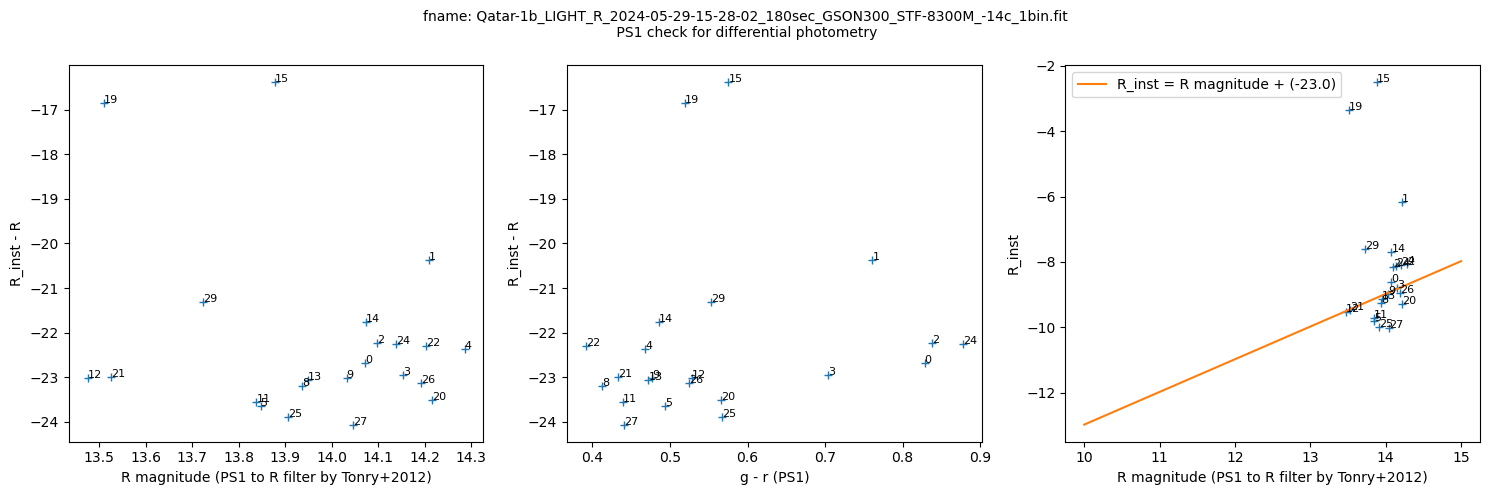

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False, gridspec_kw=None)

axs[0].plot(phot_stars_na[f"{flt}mag"], phot_stars_na["mag"] - phot_stars_na[f"{flt}mag"], '+')
axs[1].plot(phot_stars_na["grcolor"], phot_stars_na["mag"] - phot_stars_na[f"{flt}mag"], '+')
_xx = np.linspace(10, 15)
axs[2].plot(phot_stars_na[f"{flt}mag"], phot_stars_na["mag"], '+')
y0 = np.median(phot_stars_na["mag"] - phot_stars_na[f"{flt}mag"])
axs[2].plot(_xx, _xx + y0,
         label=f"{flt}_inst = {flt} magnitude + ({y0:.01f})"
         )

for _, row in phot_stars_na.iterrows():
    axs[0].text(row[f"{flt}mag"], row["mag"] - row[f"{flt}mag"], int(row["id"]), fontsize=8)
    axs[1].text(row["grcolor"], row["mag"] - row[f"{flt}mag"], int(row["id"]), fontsize=8)
    axs[2].text(row[f"{flt}mag"], row["mag"], int(row["id"]), fontsize=8)
    
axs[0].set(
    xlabel=f"{flt} magnitude (PS1 to {flt} filter by Tonry+2012)",
    ylabel=f"{flt}_inst - {flt}"
)
axs[1].set(
    xlabel="g - r (PS1)",
    ylabel=f"{flt}_inst - {flt}"
)
axs[2].set(
    xlabel =f"{flt} magnitude (PS1 to {flt} filter by Tonry+2012)",
    ylabel =f"{flt}_inst"
)
axs[2].legend()

plt.suptitle(f"fname: {fpath.name}\n PS1 check for differential photometry", fontsize=10,)

plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_standardization.png")

# plt.show()
# plt.close()

In [48]:
phot_stars_na.columns

Index(['id', 'xcenter', 'ycenter', 'aperture_sum', 'aperture_sum_err', 'msky',
       'ssky', 'nsky', 'nrej', 'aparea', 'source_sum', 'source_sum_err', 'mag',
       'merr', 'snr', 'bad', 'nbadpix', 'Rmag', 'e_Rmag', 'gmag', 'e_gmag',
       'rmag', 'e_rmag', 'grcolor', 'e_grcolor', 'objID'],
      dtype='object')

In [49]:
from scipy.optimize import curve_fit

def linf(x, a, b):
    return a + b*x

mcat, dmcat = phot_stars_na[f"{flt}mag"], phot_stars_na[f"e_{flt}mag"]
mobs, dmobs = phot_stars_na["mag"], phot_stars_na["merr"]
color = phot_stars_na["grcolor"]
dmtot = np.sqrt(dmcat**2 + dmobs**2)


In [50]:
# === Calculate zero point and errors
zeropt = np.average(mobs - mcat, weights=1/dmtot**2)
dzeropt = np.max([1/np.sqrt(np.sum(1/dmtot**2)), np.std(mobs - mcat, ddof=1)/np.sqrt(len(mcat))])
dmtot2 = np.sqrt(dmtot**2 + dzeropt**2)

# === Find fitting lines
# Search for the usage of scipy.optimize.curve_fit.
poptm, _ = curve_fit(linf, mcat, mobs, sigma=dmobs, absolute_sigma=True)
poptc, _ = curve_fit(linf, color, mobs-mcat, sigma=dmtot2, absolute_sigma=True)


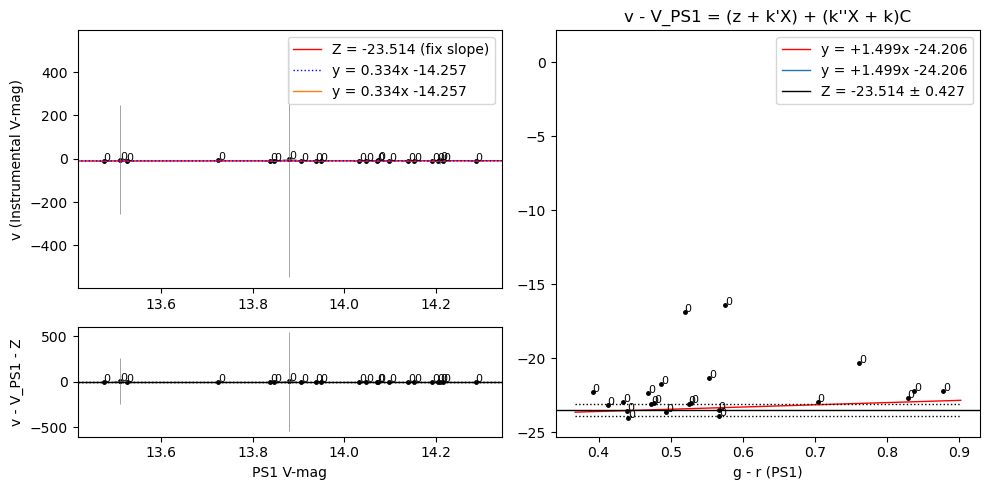

In [61]:
# === Plot
# --- Set some useful things
errkw = dict(marker="", ls="", ecolor="gray", elinewidth=0.5)

# --- Main plot with error bars and fitting lines
fig, axs = plt.subplot_mosaic("mc\nmc\nrc", figsize=(10, 5))
# m = magnitudes, c=colors, r=residuals
axs["m"].plot(mcat, mobs, "k.", ms=5)
axs["m"].errorbar(mcat, mobs, xerr=dmcat, yerr=dmobs, **errkw)
axs["r"].plot(mcat, mobs - mcat - zeropt, "k.", ms=5)
axs["r"].errorbar(mcat, mobs - mcat - zeropt, xerr=dmcat, yerr=dmtot2, **errkw)
axs["c"].plot(color, mobs - mcat, "k.", ms=5)
# axs["c"].errorbar(color, mobs - mcat, xerr=phot["dgr"], yerr=dmtot2, **errkw)

mm = np.array(axs["m"].get_xlim())
cc = np.array(axs["c"].get_xlim())

# Fitted lines
axs["m"].plot(mm, zeropt + mm, "r-", lw=1, label=f"Z = {zeropt:+.3f} (fix slope)")
axs["m"].plot(mm, linf(mm, *poptm), "b:", lw=1, label=f"y = {poptm[1]:.3f}x {poptm[0]:+.3f}", *axs["m"].get_xlim())
axs["c"].plot(cc, linf(cc, *poptc), "r-", lw=1, label=f"y = {poptc[1]:+.3f}x {poptc[0]:+.3f}", *axs["c"].get_xlim())

# --- Some codes to make the plot prettier
# axs["m"].axhline(m_targ, color="k", lw=1, label=f"Target v = {m_targ:.3f} ± {dm_targ:.3f}")
# axs["m"].hlines([m_targ+dm_targ, m_targ-dm_targ], *axs["m"].get_xlim(), color="k", lw=1, ls=":")

for i, row in phot_stars_na.iterrows():
    axs["m"].text(row[f"{flt}mag"], row["mag"], i, fontsize=8)
    axs["r"].text(row[f"{flt}mag"], row["mag"] - row[f"{flt}mag"] - zeropt, i, fontsize=8)
    axs["c"].text(row["gmag"] - row["rmag"], row["mag"] - row[f"{flt}mag"], i, fontsize=8)

axs["m"].set(xlim=mm, ylabel="v (Instrumental V-mag)")
axs["r"].set(xlim=mm, ylim=np.array([-1, 1])*np.max(np.abs(axs["r"].get_ylim())), 
             ylabel="v - V_PS1 - Z", xlabel="PS1 V-mag")
axs["c"].set(title="v - V_PS1 = (z + k'X) + (k''X + k)C", xlabel="g - r (PS1)")

axs["r"].axhline(0, color="k", lw=1)
axs["r"].hlines([dzeropt, -dzeropt], *mm, color="k", lw=1, ls=":" )
axs["c"].axhline(zeropt, color="k", lw=1, label=f"Z = {zeropt:.3f} ± {dzeropt:.3f}")
axs["c"].hlines([zeropt+dzeropt, zeropt-dzeropt], *cc, color="k", lw=1, ls=":" )

axs["m"].legend(fontsize=10)
axs["c"].legend(fontsize=10)

plt.tight_layout()
plt.show()

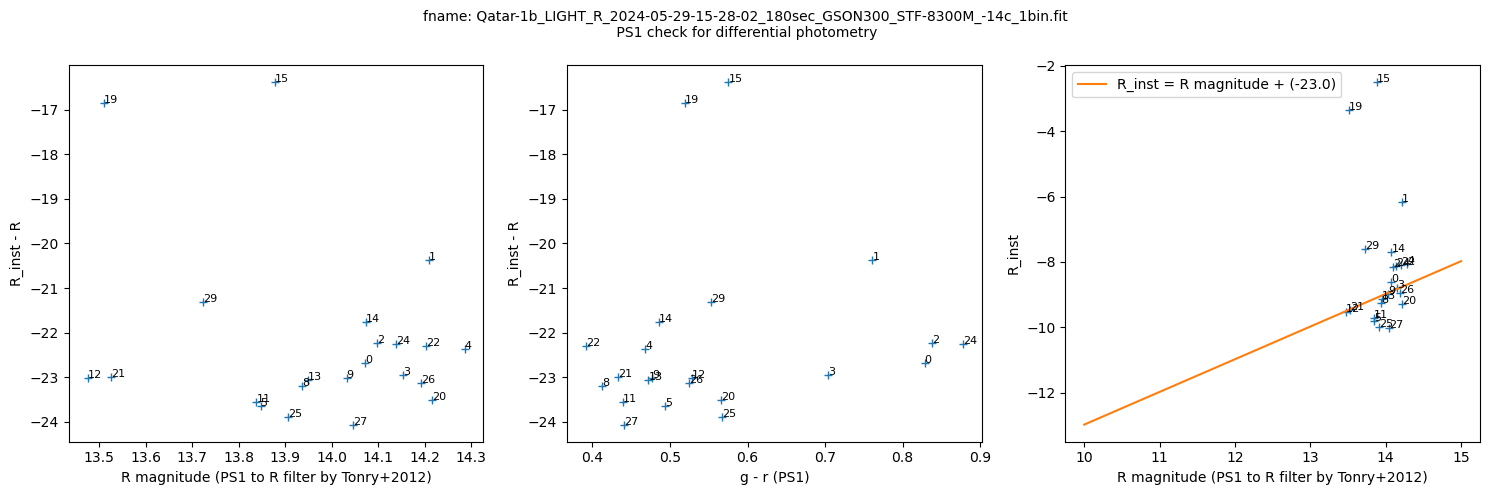

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False, gridspec_kw=None)

axs[0].plot(phot_stars_na[f"{flt}mag"], phot_stars_na["mag"] - phot_stars_na[f"{flt}mag"], '+')
axs[1].plot(phot_stars_na["grcolor"], phot_stars_na["mag"] - phot_stars_na[f"{flt}mag"], '+')
_xx = np.linspace(10, 15)
axs[2].plot(phot_stars_na[f"{flt}mag"], phot_stars_na["mag"], '+')
y0 = np.median(phot_stars_na["mag"] - phot_stars_na[f"{flt}mag"])
axs[2].plot(_xx, _xx + y0,
         label=f"{flt}_inst = {flt} magnitude + ({y0:.01f})"
         )

for _, row in phot_stars_na.iterrows():
    axs[0].text(row[f"{flt}mag"], row["mag"] - row[f"{flt}mag"], int(row["id"]), fontsize=8)
    axs[1].text(row["grcolor"], row["mag"] - row[f"{flt}mag"], int(row["id"]), fontsize=8)
    axs[2].text(row[f"{flt}mag"], row["mag"], int(row["id"]), fontsize=8)
    
axs[0].set(
    xlabel=f"{flt} magnitude (PS1 to {flt} filter by Tonry+2012)",
    ylabel=f"{flt}_inst - {flt}"
)
axs[1].set(
    xlabel="g - r (PS1)",
    ylabel=f"{flt}_inst - {flt}"
)
axs[2].set(
    xlabel =f"{flt} magnitude (PS1 to {flt} filter by Tonry+2012)",
    ylabel =f"{flt}_inst"
)
axs[2].legend()

plt.suptitle(f"fname: {fpath.name}\n PS1 check for differential photometry", fontsize=10,)

plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_standardization.png")

# plt.show()
# plt.close()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

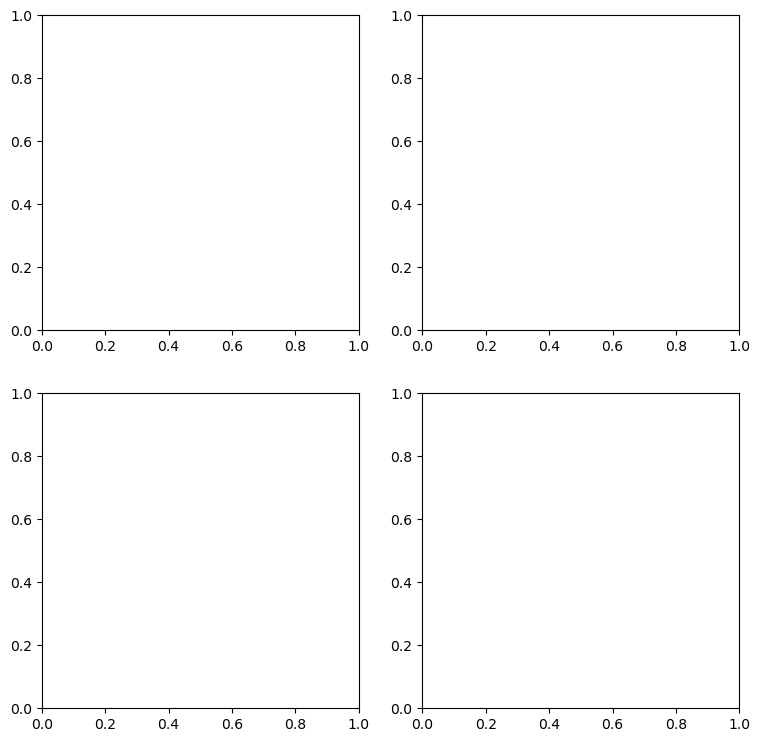

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharex=False, sharey=False, gridspec_kw=None)

axs[0].plot(phot_stars_na[f"{flt}mag"], phot_stars_na["mag"] - phot_stars_na[f"{flt}mag"], '+')
axs[1].plot(phot_stars_na["grcolor"], phot_stars_na["mag"] - phot_stars_na[f"{flt}mag"], '+')
for _, row in phot_stars_na.iterrows():
    axs[0].text(row[f"{flt}mag"], row["mag"] - row[f"{flt}mag"], int(row["id"]), fontsize=8)
    axs[1].text(row["grcolor"], row["mag"] - row[f"{flt}mag"], int(row["id"]), fontsize=8)
    
axs[0].set(
    xlabel=f"{flt} magnitude (PS1 to {flt} filter by Tonry+2012)",
    ylabel=f"{flt}_inst - {flt}"
)
axs[1].set(
    xlabel=f"g - r (PS1)",
    ylabel=f"{flt}_inst - {flt}"
)

plt.suptitle(f"fname: {fpath.name}\n PS1 check for differential photometry", fontsize=10,)

plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_standardization1.png")

# plt.show()
# plt.close()

NameError: name 'phot_stars_na' is not defined

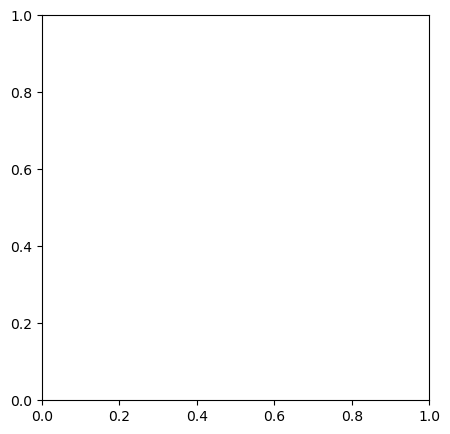

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharex=False, sharey=False, gridspec_kw=None)

_xx = np.linspace(10, 15)
axs.plot(phot_stars_na[f"{flt}mag"], phot_stars_na["mag"], '+')
# axs.axhline(phot_stars_na["mag"], label="#1 star, instrumental mag")
y0 = np.median(phot_stars_na["mag"] - phot_stars_na[f"{flt}mag"])
axs.plot(_xx, _xx + y0,
         label=f"{flt}_inst = {flt} magnitude + ({y0:.01f})"
         )

for _, row in phot_stars_na.iterrows():
    axs.text(row[f"{flt}mag"], row["mag"], int(row["id"]), fontsize=8)

axs.set(
    xlabel =f"{flt} magnitude (PS1 to {flt} filter by Tonry+2012)",
    ylabel =f"{flt}_inst"
)
axs.legend()

plt.title(f"fname: {fpath.name}\n find y0", fontsize=8,)
plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_standardization2.png")
# plt.show()
# plt.close()

In [ ]:
print(pos_sky, pos_pix)

q_stars = ps1.queried.copy()  # This will be overridden: see below
pos_stars = np.array([q_stars["x"], q_stars["y"]]).T
print(pos_stars, pos_stars)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (284.50709288, 69.56011209)> (array(1669.74423093), array(1271.29403069))
[[1801.78394198 1233.4319718 ]
 [1746.55999114 1509.49233197]
 [1955.72016809 1277.46057358]
 [1815.81401041  916.67704834]
 [1296.32949491 1026.15342541]
 [2152.20910102 1192.41375513]
 [1862.60687086 1713.33223218]
 [1715.50906957  771.8711184 ]
 [1415.38290847  835.05041558]
 [1520.73737749  771.99433649]
 [2131.74979997 1010.66409496]
 [1304.95941966  838.16808982]
 [2143.0501031  1600.72024827]
 [2214.39646692 1041.47747197]
 [1535.80824179 1835.63021566]
 [1519.94210617  686.16373086]
 [1068.83833874 1205.69879271]
 [1663.98701464 1938.65851328]
 [2329.03401993 1052.34700423]
 [1994.2406747   628.55868826]
 [1243.97275102  651.05031446]
 [1724.48637113  508.60862308]
 [2388.70142846 1627.45514266]
 [ 938.10063363 1692.43969396]
 [1290.7873268  2032.95852756]
 [2268.73165638 1907.79705183]
 [2371.20129693  707.70720255]
 [2062.24154575  380.32464656]
 [19

# DAOStar finder

In [ ]:
FWHM = FWHM_INIT
avg, med, std = sigma_clipped_stats(hdul[0].data)  # by default, 3-sigma 5-iteration.
thresh = 5. * std

DAOfind = DAOStarFinder(
                        fwhm = FWHM,
                        threshold=thresh,   # In reality, FWHM must be measured a priori using, e.g., ``ginga``
                        sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
                        roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                        sigma_radius=1.5,           # default values 1.5
                        ratio=1.0,                  # 1.0: circular gaussian
                        exclude_border=True         # To exclude sources near edges
                        )

DAOfound = DAOfind(hdul[0].data)
print("len(DAOfound) :",len(DAOfound))
print(DAOfound.colnames)

DAOfound.write(f"{DIFFPRESULTDIR/fpath.stem}_DAOStarfinder_fwhm_{FWHM}.csv",
                            overwrite = True,
                            format='ascii.fast_csv')
df_DAO = DAOfound.to_pandas()
print(type(df_DAO))
df_DAO

len(DAOfound) : 16
['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']
<class 'pandas.core.frame.DataFrame'>


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1,2268.271922,67.391926,0.580277,-0.313556,0.674465,49,0.0,31150.724609,1.396402,-0.362526
1,2,2777.478359,313.707522,0.571663,-0.473843,0.581117,49,0.0,30517.960938,1.129312,-0.132034
2,3,2793.468791,318.512981,0.322184,-0.839442,0.864121,49,0.0,29087.716797,1.868585,-0.678782
3,4,2477.643586,799.905860,0.368462,-0.254164,0.575044,49,0.0,30603.605469,1.660817,-0.550805
4,5,2006.831022,931.229517,0.589640,-0.249703,0.612883,49,0.0,30008.761719,1.072391,-0.075882
5,6,2786.519812,1379.289034,0.200986,0.914032,-0.517960,49,0.0,28347.728516,1.088430,-0.092002
6,7,1357.871837,1397.007224,0.292050,-0.299853,0.778645,49,0.0,29182.724609,1.034250,-0.036564
7,8,2585.116430,1679.677572,0.397122,-0.313444,0.925341,49,0.0,33950.937500,3.806864,-1.451418
8,9,2402.518253,1683.514013,0.374842,-0.032524,0.779450,49,0.0,29418.326172,1.058745,-0.061978
9,10,2594.595047,1703.559271,0.518495,-0.973877,-0.365888,49,0.0,30123.453125,1.272840,-0.261934


확인해 보자.

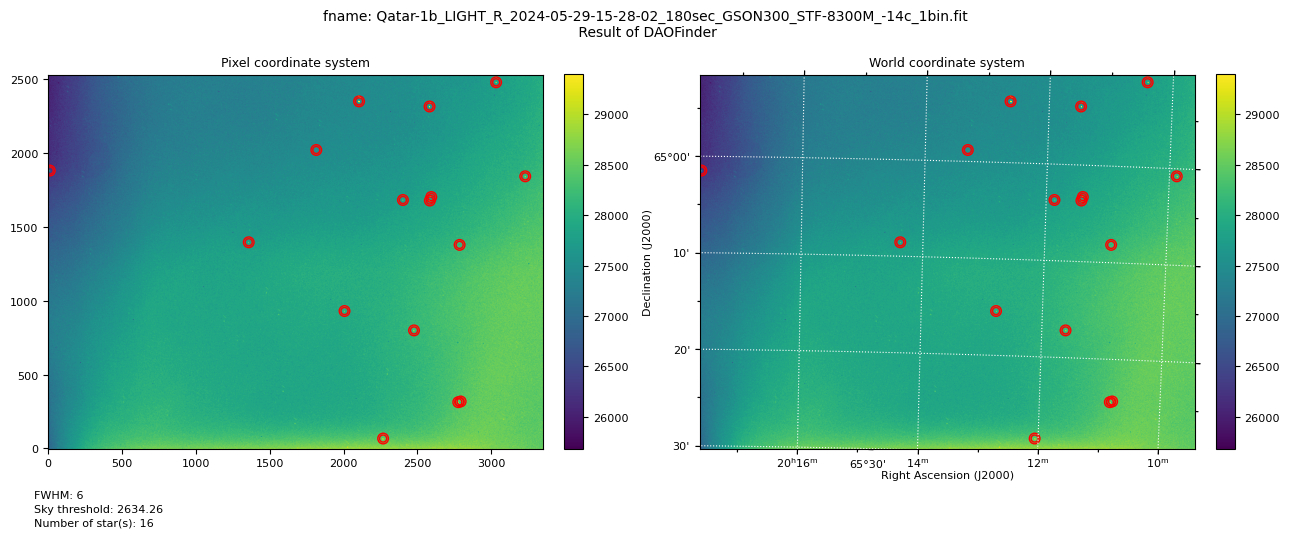

In [ ]:
pos = np.transpose((DAOfound['xcentroid'], DAOfound['ycentroid']))
apert = CAp(pos, r=R_AP)
annul = CAn(positions=pos, r_in= R_IN, r_out=R_OUT)

fig_set = plt.figure(figsize=val_figsize)

ax1 = plt.subplot2grid((1,2), (0,0),
                    fig=fig_set)
im1 = _tool_visualization.zimshow(ax1, hdul[0].data, )
ax1.set_title('Pixel coordinate system', fontsize=9)
ax1.tick_params(labelsize=8)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)
im2 = _tool_visualization.zimshow(ax2, hdul[0].data, )
ax2.set_title('World coordinate system', fontsize=9)
ax2.coords.grid(True, color='white', ls=':')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
ax2.coords['dec'].set_ticklabel_position('bl')
ax2.coords['ra'].set_major_formatter('hh:mm')
ax2.coords['dec'].set_major_formatter('dd:mm')
ax2.coords['ra'].display_minor_ticks(True)
ax2.coords['dec'].display_minor_ticks(True)
ax2.coords['ra'].set_minor_frequency(2)
ax2.coords['dec'].set_minor_frequency(2)
ax2.tick_params(labelsize=8)

annul.plot(ax1, color="r")
annul.plot(ax2, color="r")

cbar1 = plt.colorbar(im1, ax = ax1, fraction=val_fraction, pad=0.04)
cbar2 = plt.colorbar(im2, ax = ax2, fraction=val_fraction, pad=0.04, )
cbar1.ax.tick_params(labelsize=8)
cbar2.ax.tick_params(labelsize=8)

plt.suptitle(f"fname: {fpath.name}\n Result of DAOFinder", fontsize=10,)

ax1.annotate(f'FWHM: {FWHM}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

ax1.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
    xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

ax1.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR/fpath.stem}_DAOStarfinder_fwhm_{FWHM}.png")

# plt.show()
# plt.close()

In [ ]:
pos = np.transpose((DAOfound['xcentroid'], DAOfound['ycentroid']))
apert = CAp(pos, r=R_AP)
annul = CAn(positions=pos, r_in= R_IN, r_out=R_OUT)
pos

array([[2268.27192241,   67.39192594],
       [2777.47835884,  313.70752219],
       [2793.46879108,  318.51298057],
       [2477.64358561,  799.90585972],
       [2006.83102153,  931.22951653],
       [2786.51981199, 1379.28903403],
       [1357.87183699, 1397.00722357],
       [2585.11643048, 1679.67757188],
       [2402.51825279, 1683.51401262],
       [2594.59504742, 1703.55927099],
       [3231.14555595, 1843.79445673],
       [  10.06409945, 1882.90033006],
       [1815.64795425, 2022.14557736],
       [2582.92757841, 2316.81707637],
       [2105.30730768, 2351.64137569],
       [3033.93676686, 2480.86606959]])

# PS1과 DAOfound 목록 비교

In [ ]:
apphot_result = apphot(hdul[0].data, apert, method='center')
print(type(apphot_result))
# df_apphot = pd.DataFrame()
# apphot_result
df_apphot = apphot_result.to_pandas()
print(type(df_apphot))
df_apphot

<class 'astropy.table.table.QTable'>
<class 'pandas.core.frame.DataFrame'>


,id,xcenter,ycenter,aperture_sum
0,1,2268.271922,67.391926,7.320915e+06
1,2,2777.478359,313.707522,7.291080e+06
2,3,2793.468791,318.512981,7.249645e+06
3,4,2477.643586,799.905860,7.229213e+06
4,5,2006.831022,931.229517,7.180312e+06
5,6,2786.519812,1379.289034,7.169930e+06
6,7,1357.871837,1397.007224,6.997250e+06
7,8,2585.116430,1679.677572,7.322941e+06
8,9,2402.518253,1683.514013,7.167058e+06
9,10,2594.595047,1703.559271,7.229521e+06


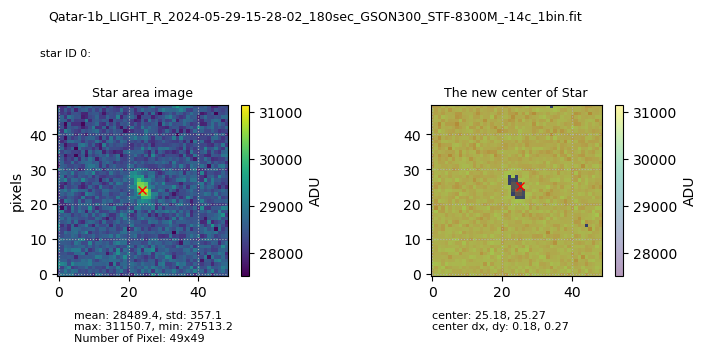

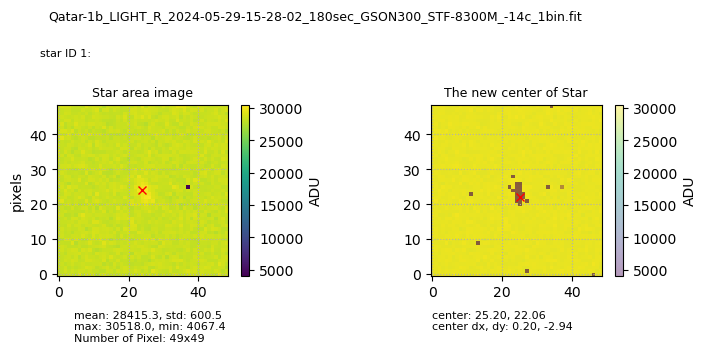

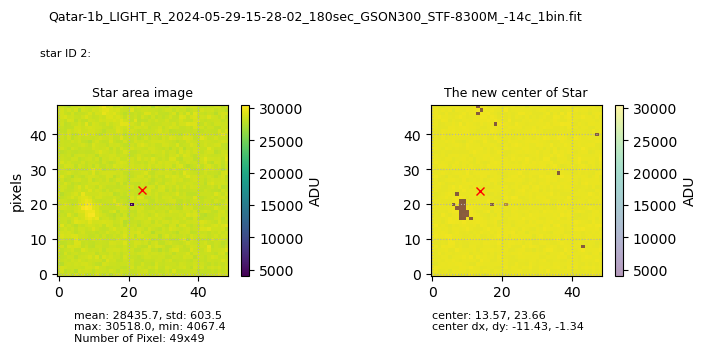

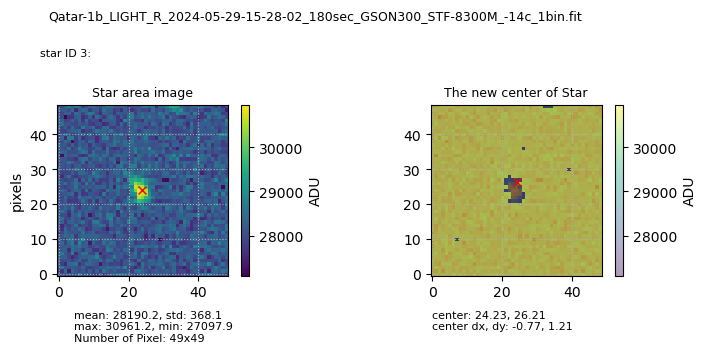

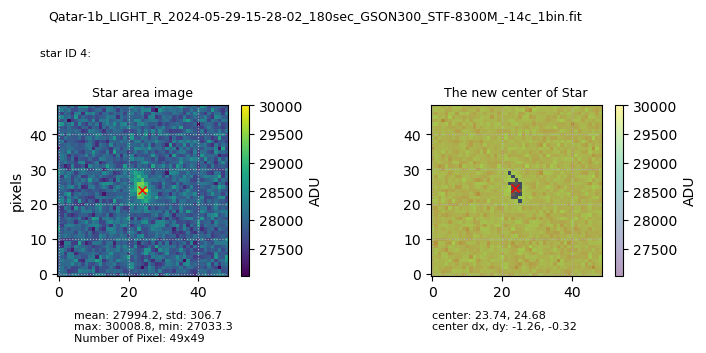

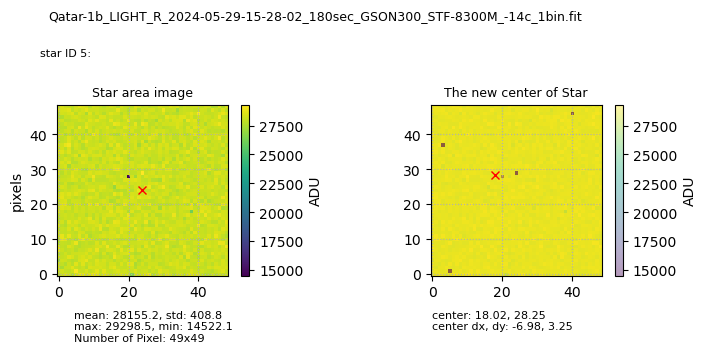

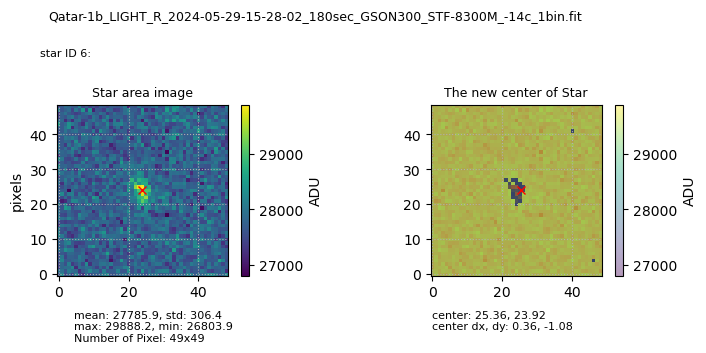

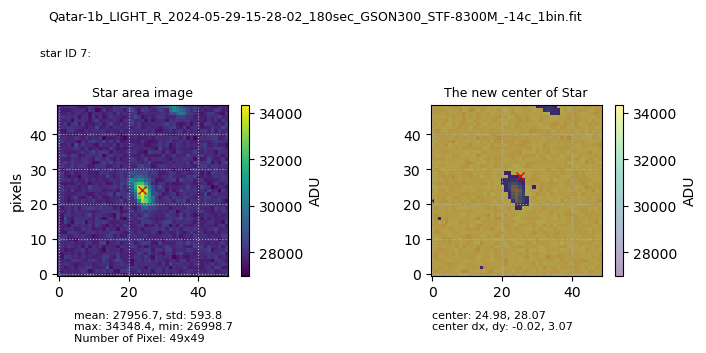

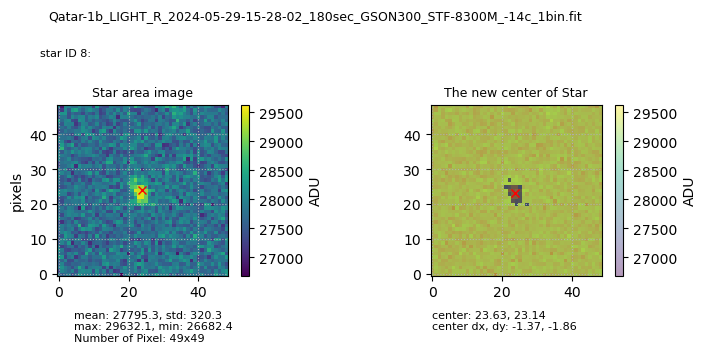

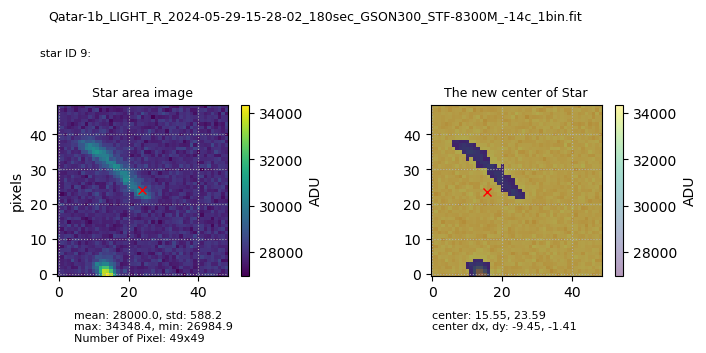

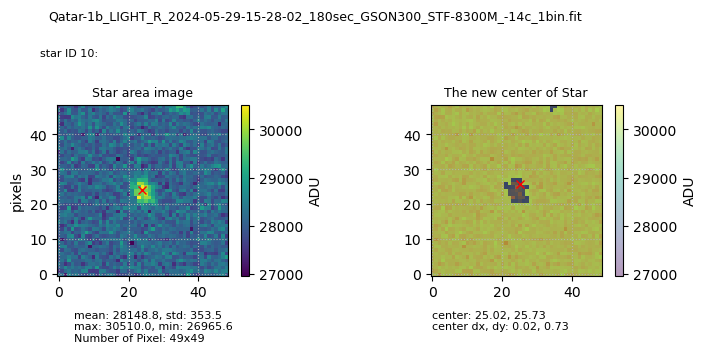

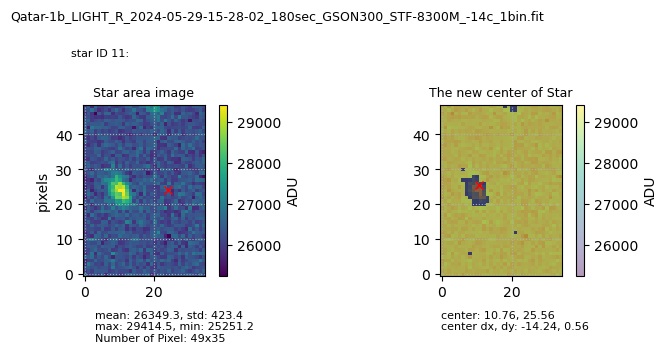

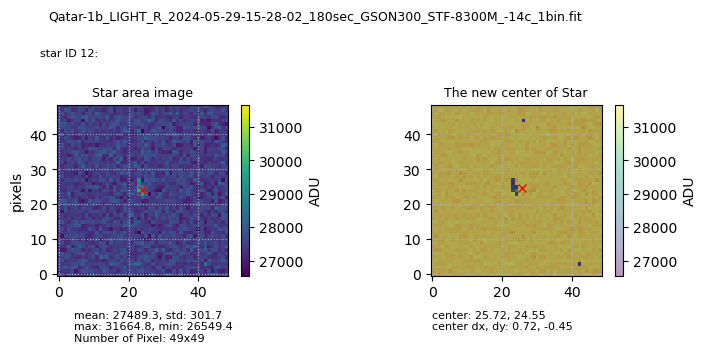

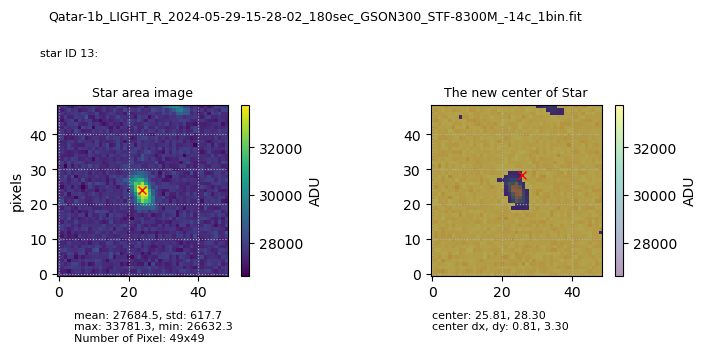

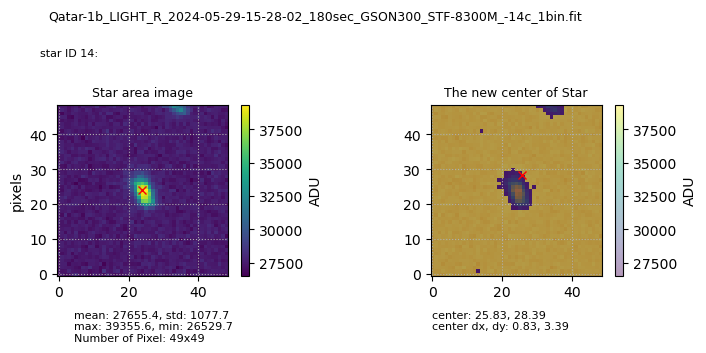

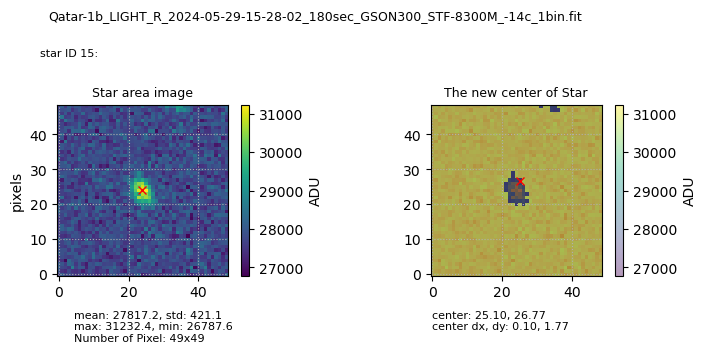

In [ ]:
# cutsizes = 49
# for idx, row in df_apphot.iterrows():
#     #1. cut asteroia area
#     #print(idx)
#     try :

#         cut_hdu = Cutout2D(
#                     data = hdul[0].data,
#                     position = ((row['xcenter'],row['ycenter'])),
#                     size=(cutsizes, cutsizes) #cut ccd
#                     )
#         avg, med, std = sigma_clipped_stats(cut_hdu.data)  # by default, 3-sigma 5-iteration.

#         fig_set = plt.figure(figsize=(8, 5.5))
        
#         ax11 = plt.subplot2grid((2, 2), (0,0),
#                     fig=fig_set)
#         #im11 = _tool_visualization.zimshow(ax11, cut_hdu.data)
#         im11 = ax11.imshow(cut_hdu.data,
#                         origin="lower")

#         ax11.plot(round(cutsizes/2), round(cutsizes/2), 'rx')
#         ax11.set_ylabel('pixels')
#         ax11.grid(ls=':')
#         ax11.set_title(f'Star area image', fontsize=9)
#         ax11.annotate(   f"mean: {np.mean(cut_hdu.data):.01f}, std: {np.std(cut_hdu.data):.01f} \nmax: {np.max(cut_hdu.data):.01f}, min: {np.min(cut_hdu.data):.01f} \nNumber of Pixel: {np.shape(cut_hdu.data)[0]:.0f}x{np.shape(cut_hdu.data)[1]:.0f}",
#             xy=(0, 0), xytext=(0.1, -0.20),
#             xycoords='axes fraction',
#             va='top', ha='left',
#             fontsize=8)
#         plt.colorbar(im11,
#                     ax=ax11,
#                     label="ADU",
#                     fraction=0.0455, pad=0.04)
#         #print("Image size is: ", cut_hdu.data.shape)

#         #2. Get center dx, dy
#         thresh_3sig = med + 3 * std
#         mask_3sig = (cut_hdu.data < thresh_3sig)
#         center = centroid_com(
#                     data = cut_hdu.data,
#                     mask = mask_3sig
#                     )

#         centerdx = center[0] - ((cutsizes+1)/2)
#         centerdy = center[1] - ((cutsizes+1)/2)
#         # print("type(center):", type(center))
#         # print("center:", center)
#         # print("center dx, dy:", centerdx, centerdy)

#         ax12 = plt.subplot2grid((2,2), (0,1),
#                     fig=fig_set)
#         ax12.grid(ls=':')
#         ax12.set_title(f'The new center of Star', fontsize=9)
#         im12 = ax12.imshow(mask_3sig.astype(int),
#             origin="lower")
#         im12 = ax12.imshow(cut_hdu.data,
#                 alpha=0.4,
#                 origin="lower")
#         ax12.plot(*center, 'rx')
#         ax12.annotate(f"center: {center[0]:.02f}, {center[1]:.02f}\ncenter dx, dy: {centerdx:.02f}, {centerdy:.02f}",
#                 xy=(0, 0), xytext=(0.01, -0.20),
#                 xycoords='axes fraction',
#                 va='top', ha='left',
#                 fontsize=8)
        
#         ax11.annotate(f"star ID {idx}: ",
#                 xy=(1, 0), xytext=(-0.1, 1.33),
#                 xycoords='axes fraction',
#                 va='top', ha='left',
#                 fontsize=8)
        
#         plt.colorbar(im12,
#                     ax=ax12,
#                     label="ADU",
#                     fraction=0.0455, pad=0.04)
#         plt.suptitle(f"{fpath.name}", 
#                     fontsize=9)
        
#         plt.tight_layout()
#         # plt.savefig(f"{DIFFPRESULTDIR/fpath.stem}_Star_{idx:03d}.png")
#         # plt.show()
#         # plt.close()
#     except : 
#         continue

# 기기등급 구하기

In [ ]:
ap_area  = apert.area
ap_area

# since our `annul` has many elements,
mask_apert = (apert.to_mask(method='center'))
mask_annul = (annul.to_mask(method='center'))

mag_ann  = np.zeros(len(apphot_result))
merr_ann = np.zeros(len(apphot_result))

# 구경측광 하기

In [ ]:
for i in range(len(apphot_result)):
    annul_weighted = mask_annul[i].multiply(hdul[0].data)
    sky_non0   = np.nonzero(annul_weighted)
    sky_pixel  = annul_weighted[sky_non0]
    
    msky, sky_std, nsky, nrej = _astro_utilities.sky_fit(sky_pixel, method='mode', 
                                                        mode_option='sex')

    flux_star = apphot_result['aperture_sum'][i] - msky * ap_area  # total - sky

    flux_err  = np.sqrt(apphot_result['aperture_sum'][i] * gain    # Poissonian (star + sky)
                        + ap_area * rdnoise**2 # Gaussian
                        + (ap_area * (gain * sky_std))**2 / nsky )

    mag_ann[i], merr_ann[i] = mag_inst(flux_star, flux_err)
    df_apphot.at[i, 'msky'] = msky
    df_apphot.at[i, 'sky_std'] = sky_std
    df_apphot.at[i, 'nsky'] = nsky
    df_apphot.at[i, 'nrej'] = nrej
    df_apphot.at[i, 'flux_star'] = flux_star
    df_apphot.at[i, 'flux_err'] = flux_err
    df_apphot.at[i, 'mag_ann'] = mag_ann[i]
    df_apphot.at[i, 'merr_ann'] = merr_ann[i]

sky = wcs.pixel_to_world(df_apphot['xcenter'], df_apphot['ycenter'])
sky
# df_apphot.to_csv(f"{INSTRESULTDIR}/{fpath.stem}_m_inst.csv")
df_apphot

/tmp/ipykernel_14297/3711488807.py:3: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)


,id,xcenter,ycenter,aperture_sum,msky,sky_std,nsky,nrej,flux_star,flux_err,mag_ann,merr_ann
0,1,2268.271922,67.391926,7.320915e+06,28461.079629,321.726038,2250.0,12.0,78452.061120,1771.598825,-12.236511,0.024518
1,2,2777.478359,313.707522,7.291080e+06,28396.126981,313.412031,2246.0,13.0,65146.320921,1762.784139,-12.034725,0.029379
2,3,2793.468791,318.512981,7.249645e+06,28436.441550,316.991548,2245.0,11.0,13451.994991,1761.011053,-10.321967,0.142135
3,4,2477.643586,799.905860,7.229213e+06,28180.016894,300.007127,2233.0,24.0,58272.395641,1747.606927,-11.913657,0.032562
4,5,2006.831022,931.229517,7.180312e+06,27970.004822,286.131059,2247.0,13.0,62812.904095,1732.548061,-11.995122,0.029948
5,6,2786.519812,1379.289034,7.169930e+06,28152.079549,290.797187,2247.0,13.0,6098.462046,1734.503390,-9.463051,0.308801
6,7,1357.871837,1397.007224,6.997250e+06,27740.359486,274.364974,2253.0,9.0,-61811.655451,1705.045700,NaN,-0.029950
7,8,2585.116430,1679.677572,7.322941e+06,27869.421617,294.499669,2180.0,80.0,231036.893600,1756.183828,-13.409203,0.008253
8,9,2402.518253,1683.514013,7.167058e+06,27787.980925,292.249463,2249.0,8.0,95878.597908,1735.073606,-12.454304,0.019648
9,10,2594.595047,1703.559271,7.229521e+06,27886.408784,288.668242,2220.0,43.0,133294.434325,1740.598173,-12.812030,0.014178


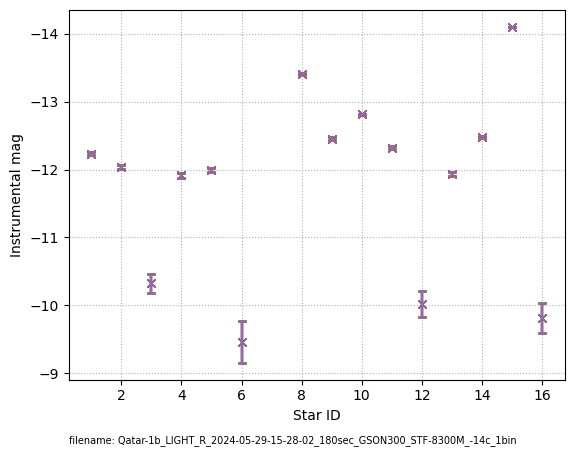

In [ ]:
df_apphot_sub = df_apphot.dropna()
df_apphot_sub

fig, ax = plt.subplots()

for idx, row in df_apphot_sub.iterrows():

    ax.errorbar(df_apphot_sub["id"], 
                df_apphot_sub["mag_ann"], yerr=df_apphot_sub["merr_ann"],
                marker='x',
                ls='none',
                #ms=10,
                capsize=3)

ax.invert_yaxis()
# ax.set_ylim(ymin=-20, ymax=0)

ax.annotate(f'filename: {fpath.stem}', fontsize=7,
    xy=(0, 0), xytext=(0, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.xlabel('Star ID')
plt.ylabel('Instrumental mag')
plt.grid(ls=':')

plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_m_inst_chart.png")
# plt.show()
# plt.close()

In [ ]:
sky_coord = wcs.pixel_to_world(df_apphot['xcenter'], df_apphot['ycenter'])
sky_coord
print(type(sky_coord))
#sky_coord[0]

dir(sky_coord)
len(sky_coord.ra)
# df_apphot["RA2000"] = sky_coord.ra
# df_apphot["RA2000"]
df_RADEC = pd.DataFrame({"RAJ2000": sky_coord.ra.degree, "DEJ2000": sky_coord.dec.degree})
df_RADEC
#type(df_RADEC["RA2000"][0])

<class 'astropy.coordinates.sky_coordinate.SkyCoord'>


,RAJ2000,DEJ2000
0,303.014258,65.474628
1,302.707977,65.407257
2,302.698315,65.405877
3,302.902000,65.286289
4,303.191229,65.256792
5,302.727453,65.135882
6,303.593214,65.142654
7,302.855912,65.061272
8,302.966246,65.061918
9,302.850708,65.055103


In [ ]:
df_apphot = pd.concat([df_apphot, df_RADEC], axis=1,)
df_apphot['filename'] = fpath.stem
df_apphot['t_start'] = t_start
df_apphot['t_expos'] = t_expos
df_apphot['t_middle'] = t_middle
df_apphot['filter'] = flt

df_apphot

,id,xcenter,ycenter,aperture_sum,msky,sky_std,nsky,nrej,flux_star,flux_err,mag_ann,merr_ann,RAJ2000,DEJ2000,filename,t_start,t_expos,t_middle
0,1,2268.271922,67.391926,7.320915e+06,28461.079629,321.726038,2250.0,12.0,78452.061120,1771.598825,-12.236511,0.024518,303.014258,65.474628,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900
1,2,2777.478359,313.707522,7.291080e+06,28396.126981,313.412031,2246.0,13.0,65146.320921,1762.784139,-12.034725,0.029379,302.707977,65.407257,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900
2,3,2793.468791,318.512981,7.249645e+06,28436.441550,316.991548,2245.0,11.0,13451.994991,1761.011053,-10.321967,0.142135,302.698315,65.405877,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900
3,4,2477.643586,799.905860,7.229213e+06,28180.016894,300.007127,2233.0,24.0,58272.395641,1747.606927,-11.913657,0.032562,302.902000,65.286289,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900
4,5,2006.831022,931.229517,7.180312e+06,27970.004822,286.131059,2247.0,13.0,62812.904095,1732.548061,-11.995122,0.029948,303.191229,65.256792,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900
5,6,2786.519812,1379.289034,7.169930e+06,28152.079549,290.797187,2247.0,13.0,6098.462046,1734.503390,-9.463051,0.308801,302.727453,65.135882,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900
6,7,1357.871837,1397.007224,6.997250e+06,27740.359486,274.364974,2253.0,9.0,-61811.655451,1705.045700,NaN,-0.029950,303.593214,65.142654,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900
7,8,2585.116430,1679.677572,7.322941e+06,27869.421617,294.499669,2180.0,80.0,231036.893600,1756.183828,-13.409203,0.008253,302.855912,65.061272,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900
8,9,2402.518253,1683.514013,7.167058e+06,27787.980925,292.249463,2249.0,8.0,95878.597908,1735.073606,-12.454304,0.019648,302.966246,65.061918,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900
9,10,2594.595047,1703.559271,7.229521e+06,27886.408784,288.668242,2220.0,43.0,133294.434325,1740.598173,-12.812030,0.014178,302.850708,65.055103,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900


# 구경 측광 자료 표준화


In [ ]:
df_apphot["y0"] = y0
df_apphot

df_apphot[f"{flt}_magnitude"] = df_apphot["mag_ann"] - df_apphot["y0"]

df_apphot.to_csv(f"{DIFFPRESULTDIR}/{fpath.stem}_result_photometry.csv")
df_apphot[f"{flt}_magnitude"]

0     10.737416
1     10.939202
2     12.651960
3     11.060270
4     10.978805
5     13.510876
6           NaN
7      9.564724
8     10.519623
9     10.161897
10    10.649010
11    12.951611
12    11.038957
13    10.496422
14     8.873450
15    13.159948
Name: R_magnitude, dtype: float64

In [ ]:
df_apphot_sub = df_apphot.dropna()
df_apphot_sub

,id,xcenter,ycenter,aperture_sum,msky,sky_std,nsky,nrej,flux_star,flux_err,mag_ann,merr_ann,RAJ2000,DEJ2000,filename,t_start,t_expos,t_middle,y0,R_magnitude
0,1,2268.271922,67.391926,7.320915e+06,28461.079629,321.726038,2250.0,12.0,78452.061120,1771.598825,-12.236511,0.024518,303.014258,65.474628,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900,-22.973927,10.737416
1,2,2777.478359,313.707522,7.291080e+06,28396.126981,313.412031,2246.0,13.0,65146.320921,1762.784139,-12.034725,0.029379,302.707977,65.407257,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900,-22.973927,10.939202
2,3,2793.468791,318.512981,7.249645e+06,28436.441550,316.991548,2245.0,11.0,13451.994991,1761.011053,-10.321967,0.142135,302.698315,65.405877,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900,-22.973927,12.651960
3,4,2477.643586,799.905860,7.229213e+06,28180.016894,300.007127,2233.0,24.0,58272.395641,1747.606927,-11.913657,0.032562,302.902000,65.286289,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900,-22.973927,11.060270
4,5,2006.831022,931.229517,7.180312e+06,27970.004822,286.131059,2247.0,13.0,62812.904095,1732.548061,-11.995122,0.029948,303.191229,65.256792,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900,-22.973927,10.978805
5,6,2786.519812,1379.289034,7.169930e+06,28152.079549,290.797187,2247.0,13.0,6098.462046,1734.503390,-9.463051,0.308801,302.727453,65.135882,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900,-22.973927,13.510876
7,8,2585.116430,1679.677572,7.322941e+06,27869.421617,294.499669,2180.0,80.0,231036.893600,1756.183828,-13.409203,0.008253,302.855912,65.061272,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900,-22.973927,9.564724
8,9,2402.518253,1683.514013,7.167058e+06,27787.980925,292.249463,2249.0,8.0,95878.597908,1735.073606,-12.454304,0.019648,302.966246,65.061918,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900,-22.973927,10.519623
9,10,2594.595047,1703.559271,7.229521e+06,27886.408784,288.668242,2220.0,43.0,133294.434325,1740.598173,-12.812030,0.014178,302.850708,65.055103,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900,-22.973927,10.161897
10,11,3231.145556,1843.794457,7.238744e+06,28112.016140,304.187252,2241.0,20.0,85107.315798,1751.105812,-12.324917,0.022339,302.470184,65.013091,Qatar-1b_LIGHT_R_2024-05-29-15-28-02_180sec_GS...,2024-05-29T15:28:02.900,180.0,2024-05-29T15:29:32.900,-22.973927,10.649010


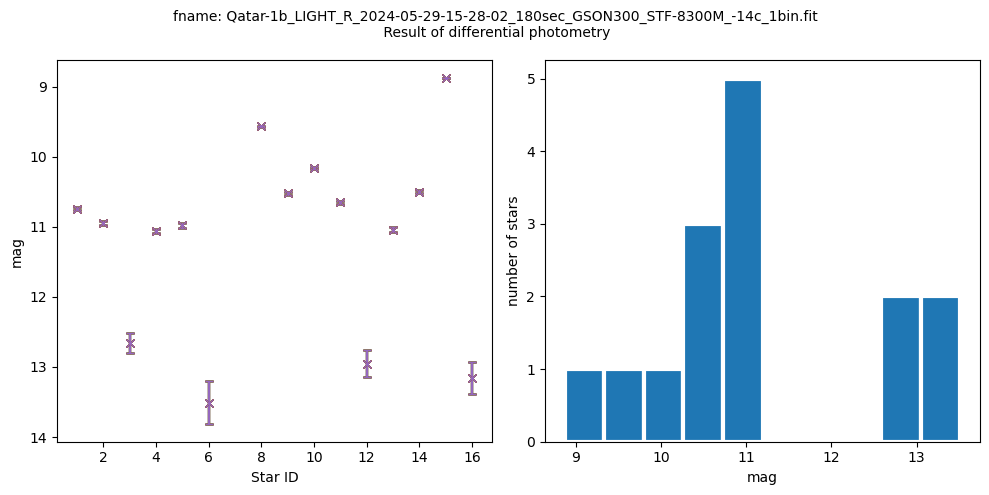

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False, gridspec_kw=None)

for idx, row in df_apphot_sub.iterrows():

    axs[0].errorbar(df_apphot_sub["id"], 
                df_apphot_sub[f"{flt}_magnitude"], yerr=df_apphot_sub["merr_ann"],
                marker='x',
                ls='none',
                #ms=10,
                capsize=3)

axs[0].invert_yaxis()

style = {'edgecolor': 'white', 'linewidth': 3}
axs[1].hist(df_apphot_sub[f"{flt}_magnitude"], 
            **style)
    
axs[0].set(
    xlabel='Star ID',
    ylabel=f"{flt}mag"
)
axs[1].set(
    xlabel=f"{flt}mag",
    ylabel="number of stars"
)

plt.suptitle(f"fname: {fpath.name}\n Result of differential photometry", fontsize=10,)

plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_standardization1.png")

# plt.show()
# plt.close()

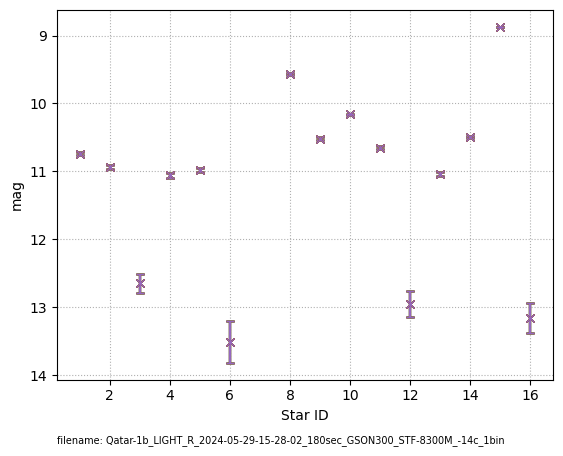

In [ ]:
fig, ax = plt.subplots()

for idx, row in df_apphot_sub.iterrows():

    ax.errorbar(df_apphot_sub["id"], 
                df_apphot_sub[f"{flt}_magnitude"], yerr=df_apphot_sub["merr_ann"],
                marker='x',
                ls='none',
                #ms=10,
                capsize=3)

ax.invert_yaxis()
# ax.set_ylim(ymin=-20, ymax=0)

ax.annotate(f'filename: {fpath.stem}', fontsize=7,
    xy=(0, 0), xytext=(0, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.xlabel('Star ID')
plt.ylabel('mag')
plt.grid(ls=':')

plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_result_photometry_chart.png")
# plt.show()
# plt.close()